In [1]:
#pip install tensorflow

In [2]:
# Librerías generales
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import itertools

# Para la evaluacion de datos
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_absolute_percentage_error
from sklearn.feature_selection import mutual_info_regression

# Para modelizacion
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, GRU, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow import keras
from keras import layers

# Cargar los datos del Bitcoin y su estudio

## Cargar datos BTC

In [3]:
# Cargar csv y convertirlo en df
df_btc = pd.read_csv('Datos Crypto/Historico_BTC_diario.csv', 
                     delimiter = ',', decimal = '.', dtype={'Fecha': str})

# Renombrar la columna
df_btc.rename(columns={ 'close': 'BTC_Close', 
                       'date':'Fecha',
                      'open':'BTC_Open','high':'BTC_Max','low':'BTC_Min','volume':'BTC_Vol'}, inplace = True)

# Columnas que deben ser numéricas
cols = ['BTC_Close', 'BTC_Max', 'BTC_Min', 'BTC_Open', 'BTC_Vol']

# Convertir columnas a numérico
for col in cols:
    df_btc[col] = pd.to_numeric(df_btc[col], errors='coerce')

# Redondear valores numéricos a 2 decimales
df_btc = df_btc.round(2)

# Convertir la columna Fecha al tipo datetime
df_btc['Fecha'] = pd.to_datetime(df_btc['Fecha'])

# Ordenar df
df_btc = df_btc.sort_values(by='Fecha', ascending=True).reset_index(drop=True)

df_btc = df_btc.reset_index(drop=True)

# Establecer fecha como indice
df_btc.set_index('Fecha', inplace=True)
df_btc.sort_index(inplace=True, ascending=True)

# Mostrar las primeras filas
df_btc.head()

,BTC_Open,BTC_Max,BTC_Min,BTC_Close,BTC_Vol
Fecha,,,,,
2018-01-01,13715.65,13818.55,12750.00,13380.00,8609.92
2018-01-02,13382.16,15473.49,12890.02,14675.11,20078.09
2018-01-03,14690.00,15307.56,14150.00,14919.51,15905.67
2018-01-04,14919.51,15280.00,13918.04,15059.54,21329.65
2018-01-05,15059.56,17176.24,14600.00,16960.39,23251.49


In [4]:
df_btc.isna().sum()

BTC_Open     0
BTC_Max      0
BTC_Min      0
BTC_Close    0
BTC_Vol      0
dtype: int64

In [5]:
df_btc.shape

(2373, 5)

In [6]:
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2373 entries, 2018-01-01 to 2024-06-30
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BTC_Open   2373 non-null   float64
 1   BTC_Max    2373 non-null   float64
 2   BTC_Min    2373 non-null   float64
 3   BTC_Close  2373 non-null   float64
 4   BTC_Vol    2373 non-null   float64
dtypes: float64(5)
memory usage: 111.2 KB


In [7]:
df_series = df_btc['BTC_Close']
df_series = df_series.asfreq('D')
df_series.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2373 entries, 2018-01-01 to 2024-06-30
Freq: D
Series name: BTC_Close
Non-Null Count  Dtype  
--------------  -----  
2373 non-null   float64
dtypes: float64(1)
memory usage: 37.1 KB


| Columna        | Descripción                                                                                                                                                                                                                                                                                                                                                                                         |
| -------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Fecha**      | Representa la fecha específica para la cual se registran los datos del mercado. Cada fila corresponde a un día calendario.                                                                                                                                                                                                                                                                                     |
| **BTC\_Close** | Precio de cierre de Bitcoin (BTC) en dólares estadounidenses (USD) para esa fecha. Es el último precio al que se negociaron BTC en los intercambios al finalizar el día.                                                                                                                                                        |
| **BTC\_Max**   | Precio máximo alcanzado por BTC durante el día. Representa el valor más alto al que se negoció Bitcoin en ese intervalo.                                                                                                                                                                                                                          |
| **BTC\_Min**   | Precio mínimo alcanzado por BTC durante el día. Representa el valor más bajo al que se negoció Bitcoin.                                                                                                                                                                                                                                         |
| **BTC\_Open**  | Precio de apertura de BTC en dólares para ese día. Es el primer precio registrado en los intercambios al comenzar la sesión diaria.                                                                                                                                                                                                       |
| **BTC\_Vol**   | Volumen de Bitcoin negociado en ese día, expresado como la cantidad total de unidades de BTC que se movieron a través de los intercambios durante el periodo. Este valor refleja la liquidez y actividad del mercado, y es un indicador importante para entender la fuerza del movimiento del precio. |

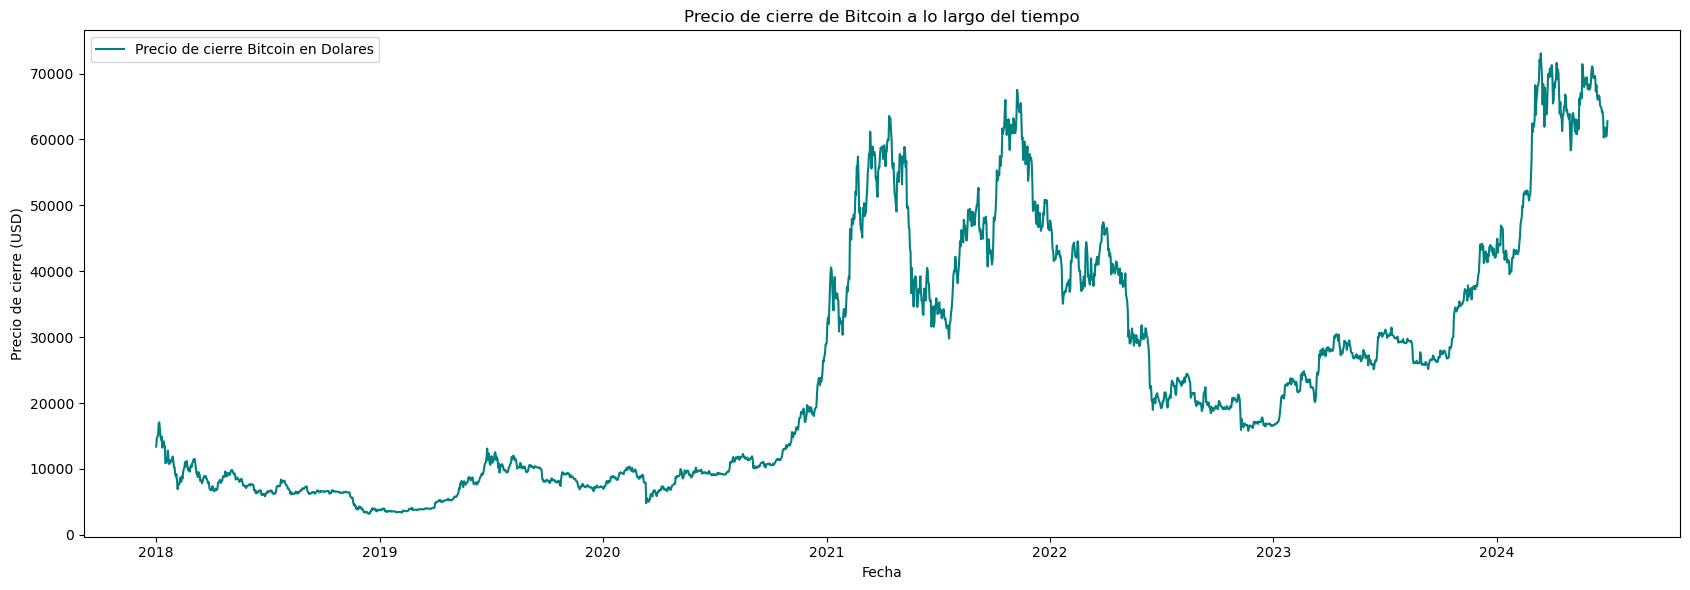

In [8]:
# Gráfico
plt.figure(figsize=(17, 6))
plt.plot(df_btc['BTC_Close'], color='teal', label='Precio de cierre Bitcoin en Dolares')


plt.title('Precio de cierre de Bitcoin a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre (USD)')
plt.legend()
plt.savefig('Datos btc utilizados')
plt.tight_layout()
plt.show()

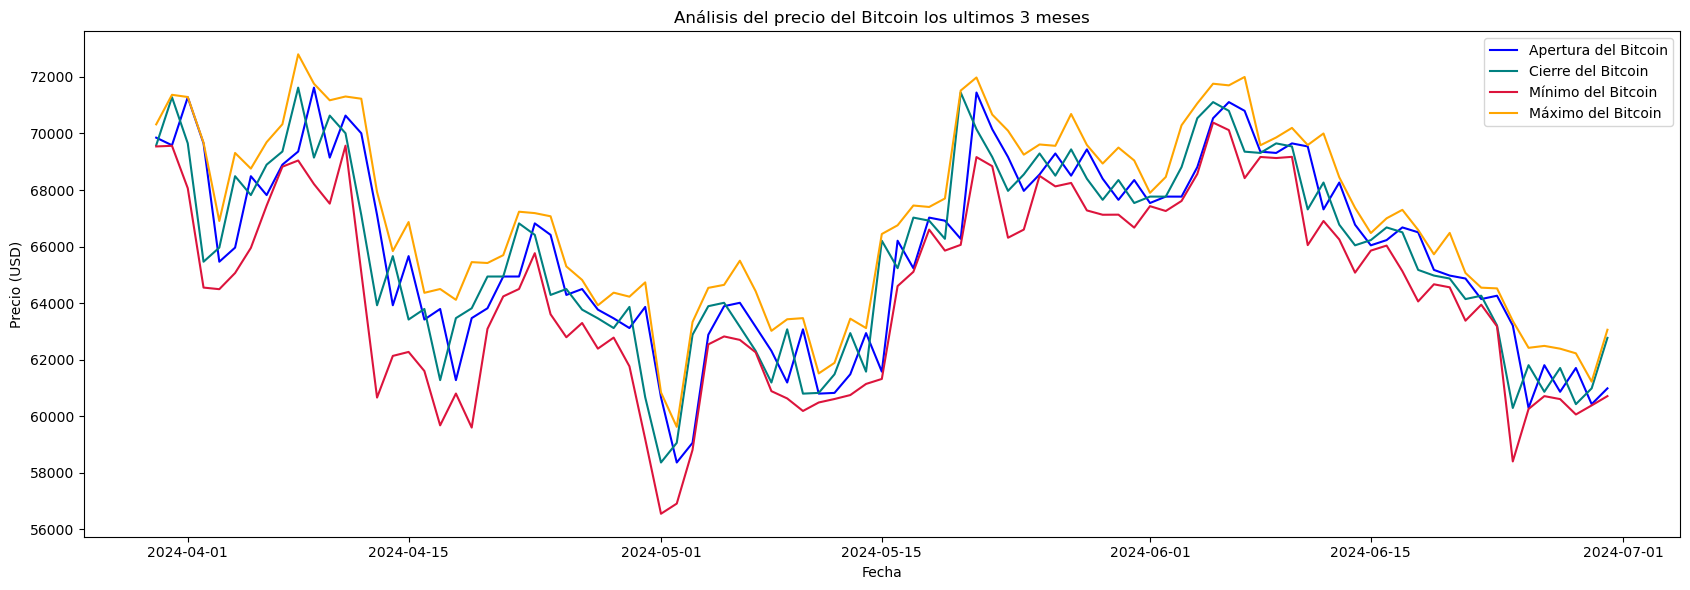

In [9]:
# Fecha máxima en el índice
fecha_max = df_btc.index.max()

# Fecha límite hace 3 meses
fecha_3m = fecha_max - pd.DateOffset(months=3)

# Filtrar últimos 3 meses
df_3mdias = df_btc[df_btc.index >= fecha_3m]

# Gráfico
plt.figure(figsize=(17, 6))
plt.plot(df_3mdias['BTC_Open'], color='blue', label='Apertura del Bitcoin')
plt.plot(df_3mdias['BTC_Close'], color='teal', label='Cierre del Bitcoin')
plt.plot(df_3mdias['BTC_Min'], color='crimson', label='Mínimo del Bitcoin')
plt.plot(df_3mdias['BTC_Max'], color='orange', label='Máximo del Bitcoin')

plt.title('Análisis del precio del Bitcoin los ultimos 3 meses')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.tight_layout()
plt.show()

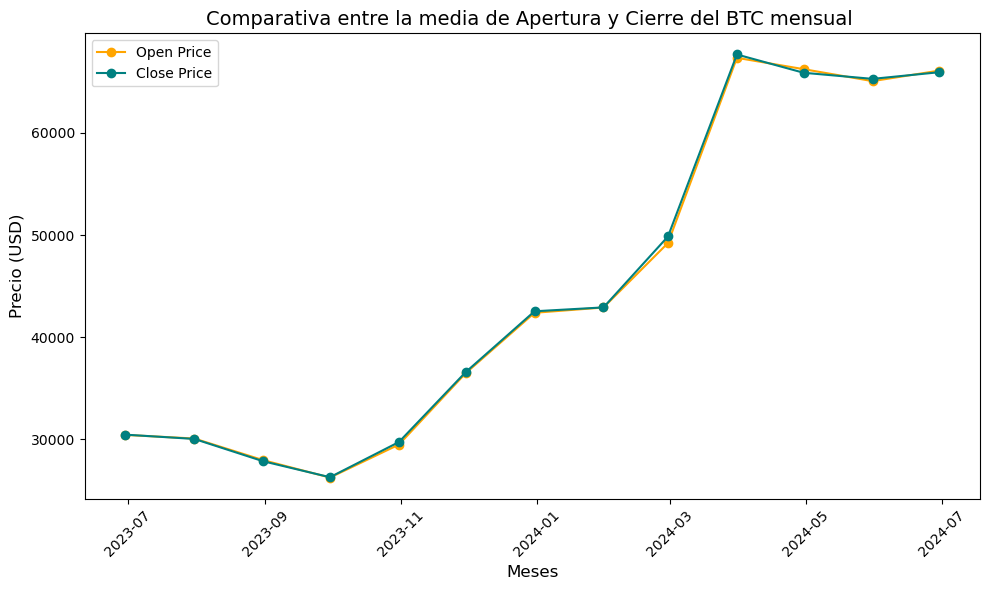

In [10]:
# Fecha límite hace 3 meses
fecha_12m = fecha_max - pd.DateOffset(months=12)

# Filtrar últimos 3 meses
df_12m = df_btc[df_btc.index >= fecha_12m]

df_12mmes = df_12m.resample('ME').mean()

# Gráfico comparativo
plt.figure(figsize=(10, 6))
plt.plot(df_12mmes.index, df_12mmes['BTC_Open'], marker='o', color= 'orange', label='Open Price')
plt.plot(df_12mmes.index, df_12mmes['BTC_Close'], marker='o', color= 'teal', label='Close Price')

plt.title('Comparativa entre la media de Apertura y Cierre del BTC mensual ', fontsize=14)
plt.xlabel('Meses', fontsize=12)
plt.ylabel('Precio (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

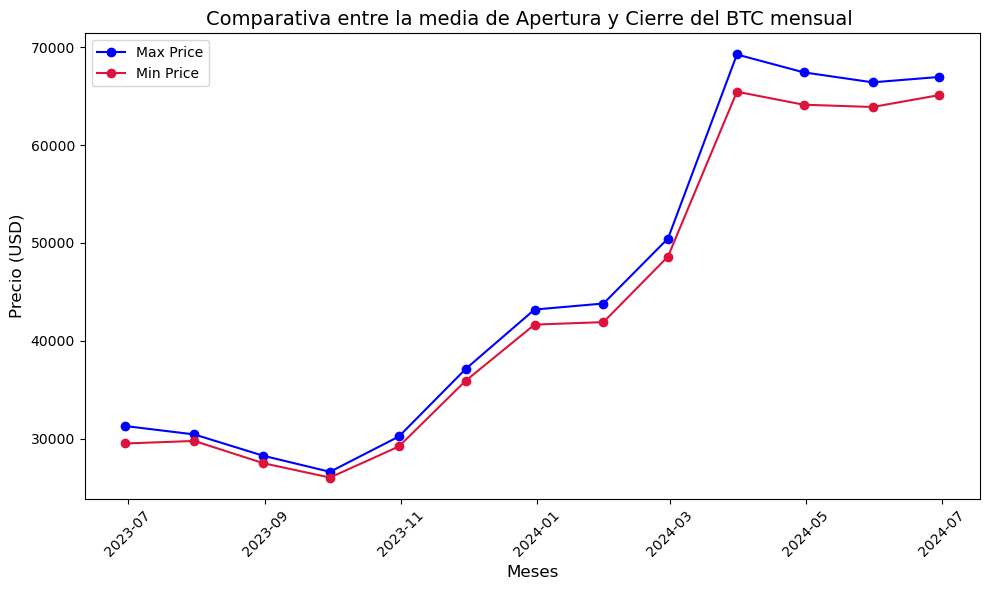

In [11]:
# Gráfico comparativo
plt.figure(figsize=(10, 6))
plt.plot(df_12mmes.index, df_12mmes['BTC_Max'], marker='o', color= 'blue', label='Max Price')
plt.plot(df_12mmes.index, df_12mmes['BTC_Min'], marker='o', color= 'crimson', label='Min Price')

plt.title('Comparativa entre la media de Apertura y Cierre del BTC mensual ', fontsize=14)
plt.xlabel('Meses', fontsize=12)
plt.ylabel('Precio (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Cargas Datos Blockchain

In [12]:
def cargar_csv_blockchain(nombre_archivo: str) -> pd.DataFrame:
    """
    Carga un CSV de 'data blockchain/', convierte la primera columna en datetime,
    la usa como índice, ordena el índice y elimina la primera columna redundante.
    
    Parámetros:
        nombre_archivo (str): Nombre del archivo CSV dentro de 'data blockchain/'.
    
    Retorna:
        pd.DataFrame: DataFrame limpio con el índice temporal.
    """
    ruta = f"data blockchain/{nombre_archivo}.csv"
    
    df = pd.read_csv(ruta, delimiter=',', decimal='.')
    
    # convertir primera columna a datetime y renombrar
    df.iloc[:,0] = pd.to_datetime(df.iloc[:,0])
    df.rename(columns={df.columns[0]: "Date"}, inplace=True)
    
    # poner esa columna como índice
    df.set_index(df.columns[0], inplace=True)
    df.sort_index(inplace=True)
    
    df.drop(columns=df.columns[0], inplace=True)
    
    return df

## CCD

In [13]:
df_cdd = cargar_csv_blockchain('cdd_2017-01-01_to_2025-06-30')
df_cdd.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,cdd
Date,
2017-01-01,7631650.82
2017-01-02,16529545.74
2017-01-03,11907939.60
2017-01-04,20949206.12
2017-01-05,47364476.06


## Hashprice

In [14]:
df_hashprice = cargar_csv_blockchain('hashprice_2017-01-01_to_2025-06-30')
df_hashprice.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,hashprice
Date,
2017-01-01,0.816846
2017-01-02,0.849237
2017-01-03,0.866148
2017-01-04,0.987329
2017-01-05,0.844867


## LTH MVRV

In [15]:
df_lth_mvrv = cargar_csv_blockchain('lth-mvrv_2017-01-01_to_2025-06-30')
df_lth_mvrv.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,lthMvrv
Date,
2017-01-01,3.052
2017-01-02,3.170
2017-01-03,3.197
2017-01-04,3.353
2017-01-05,3.272


## LTH SOPR

In [16]:
df_lth_sopr = cargar_csv_blockchain('lth-sopr_2017-01-01_to_2025-06-30')
df_lth_sopr.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,lthSopr
Date,
2017-01-01,2.063023
2017-01-02,2.461140
2017-01-03,2.540780
2017-01-04,1.901861
2017-01-05,2.260301


## MVOCDD

In [17]:
df_mvocdd = cargar_csv_blockchain('mvocdd_2017-01-01_to_2025-06-30')
df_mvocdd.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,mvocdd
Date,
2017-01-01,459.9236
2017-01-02,459.9236
2017-01-03,493.6112
2017-01-04,517.0289
2017-01-05,527.5483


## MVRV

In [18]:
df_mvrv = cargar_csv_blockchain('mvrv_2017-01-01_to_2025-06-30')
df_mvrv.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,mvrv
Date,
2017-01-01,2.348003
2017-01-02,2.382576
2017-01-03,2.405792
2017-01-04,2.613398
2017-01-05,2.295259


## NRPL BTC

In [19]:
df_nrpl = cargar_csv_blockchain('nrpl-btc_2017-01-01_to_2025-06-30')
df_nrpl.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,nrplBtc
Date,
2017-01-01,18883.757934
2017-01-02,20133.623456
2017-01-03,21683.929792
2017-01-04,24345.811955
2017-01-05,35473.086906


## NUPL

In [20]:
df_nupl = cargar_csv_blockchain('nupl_2017-01-01_to_2025-06-30')
df_nupl.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,nupl
Date,
2017-01-01,0.5656
2017-01-02,0.5718
2017-01-03,0.5759
2017-01-04,0.6090
2017-01-05,0.5530


## Puell Multiple

In [21]:
df_puell = cargar_csv_blockchain('puell-multiple_2017-01-01_to_2025-06-30')
df_puell.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,puellMultiple
Date,
2017-01-01,1.324
2017-01-02,1.387
2017-01-03,1.420
2017-01-04,1.145
2017-01-05,1.175


## Realized loss LTH

In [22]:
df_loss_lth = cargar_csv_blockchain('realized_loss_lth_2017-01-01_to_2025-06-30')
df_loss_lth.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,realizedLossLth
Date,
2017-01-01,-32.996081
2017-01-02,-33.762194
2017-01-03,-31.735008
2017-01-04,-28.817452
2017-01-05,-25.989930


## Realized profit LTH

In [23]:
df_profit_lth = cargar_csv_blockchain('realized_profit_lth_2017-01-01_to_2025-06-30')
df_profit_lth.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,realizedProfitLth
Date,
2017-01-01,8703.773924
2017-01-02,9231.548559
2017-01-03,9273.311930
2017-01-04,10234.038996
2017-01-05,19034.227464


## Realized profit STH

In [24]:
df_profit_sth = cargar_csv_blockchain('realized_profit_sth_2017-01-01_to_2025-06-30')
df_profit_sth.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,realizedProfitSth
Date,
2017-01-01,10245.976172
2017-01-02,10969.599284
2017-01-03,12474.087877
2017-01-04,14169.407863
2017-01-05,16490.839303


## SOPR

In [25]:
df_sopr = cargar_csv_blockchain('sopr_2017-01-01_to_2025-06-30')
df_sopr.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,sopr
Date,
2017-01-01,1.021277
2017-01-02,1.023964
2017-01-03,1.017764
2017-01-04,1.028720
2017-01-05,1.026585


## STH MVRV

In [26]:
df_sth_mvrv = cargar_csv_blockchain('sth-mvrv_2017-01-01_to_2025-06-30')
df_sth_mvrv.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,sthMvrv
Date,
2017-01-01,1.292
2017-01-02,1.329
2017-01-03,1.328
2017-01-04,1.365
2017-01-05,1.311


## STH SOPR

In [27]:
df_sth_sopr = cargar_csv_blockchain('sth-sopr_2017-01-01_to_2025-06-30')
df_sth_sopr.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,sthSopr
Date,
2017-01-01,1.041915
2017-01-02,1.069621
2017-01-03,1.080865
2017-01-04,1.086621
2017-01-05,1.075128


## Thermo price

In [28]:
df_thermo_price = cargar_csv_blockchain('thermo-price_2017-01-01_to_2025-06-30')
df_thermo_price.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,thermoPrice
Date,
2017-01-01,152.701469
2017-01-02,159.027057
2017-01-03,159.136811
2017-01-04,159.246462
2017-01-05,159.343030


## True Market Mean

In [29]:
df_true_market = cargar_csv_blockchain('true-market-mean_2017-01-01_to_2025-06-30')
df_true_market.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,trueMarketMean
Date,
2017-01-01,648.3660
2017-01-02,653.0503
2017-01-03,663.9118
2017-01-04,669.4429
2017-01-05,665.8703


## Value days destroyed

In [30]:
df_vdd = cargar_csv_blockchain('value-days-destroyed_2017-01-01_to_2025-06-30')
df_vdd.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,valueDaysDestroyed
Date,
2017-01-01,1.4947
2017-01-02,1.5384
2017-01-03,1.6070
2017-01-04,1.7874
2017-01-05,1.8452


## VOCDD

In [31]:
df_vocdd = cargar_csv_blockchain('vocdd_2017-01-01_to_2025-06-30')
df_vocdd.head()

D:\Users\iscor\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,vocdd
Date,
2017-01-01,473.3814
2017-01-02,1045.5551
2017-01-03,764.6258
2017-01-04,1477.7313
2017-01-05,2946.0936


# Unir df

In [32]:
df_unido = df_btc.copy()

for df in [df_cdd,df_lth_mvrv,df_hashprice, 
           df_lth_sopr, df_mvocdd, df_mvrv,
           df_nrpl, df_nupl, df_puell, df_loss_lth, df_profit_lth, 
           df_profit_sth,  df_sopr, df_sth_mvrv, df_sth_sopr,
           df_thermo_price, df_true_market, df_vdd, df_vocdd]:
    
    df_unido = df_unido.merge(df, left_index=True, right_index=True, how='left')

In [33]:
df_unido.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2373 entries, 2018-01-01 to 2024-06-30
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BTC_Open            2373 non-null   float64
 1   BTC_Max             2373 non-null   float64
 2   BTC_Min             2373 non-null   float64
 3   BTC_Close           2373 non-null   float64
 4   BTC_Vol             2373 non-null   float64
 5   cdd                 2373 non-null   float64
 6   lthMvrv             2373 non-null   float64
 7   hashprice           2373 non-null   float64
 8   lthSopr             2373 non-null   float64
 9   mvocdd              2373 non-null   float64
 10  mvrv                2373 non-null   float64
 11  nrplBtc             2373 non-null   float64
 12  nupl                2372 non-null   float64
 13  puellMultiple       2373 non-null   float64
 14  realizedLossLth     2373 non-null   float64
 15  realizedProfitLth   2373 non-null   f

In [34]:
df_unido_ffill = df_unido.ffill()

In [35]:
df_unido_ffill.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2373 entries, 2018-01-01 to 2024-06-30
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BTC_Open            2373 non-null   float64
 1   BTC_Max             2373 non-null   float64
 2   BTC_Min             2373 non-null   float64
 3   BTC_Close           2373 non-null   float64
 4   BTC_Vol             2373 non-null   float64
 5   cdd                 2373 non-null   float64
 6   lthMvrv             2373 non-null   float64
 7   hashprice           2373 non-null   float64
 8   lthSopr             2373 non-null   float64
 9   mvocdd              2373 non-null   float64
 10  mvrv                2373 non-null   float64
 11  nrplBtc             2373 non-null   float64
 12  nupl                2373 non-null   float64
 13  puellMultiple       2373 non-null   float64
 14  realizedLossLth     2373 non-null   float64
 15  realizedProfitLth   2373 non-null   f

In [36]:
df_unido_ffill.drop(columns=['BTC_Max', 'BTC_Min', 'BTC_Open'], inplace=True)

In [37]:
df_modelo = df_unido_ffill
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2373 entries, 2018-01-01 to 2024-06-30
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BTC_Close           2373 non-null   float64
 1   BTC_Vol             2373 non-null   float64
 2   cdd                 2373 non-null   float64
 3   lthMvrv             2373 non-null   float64
 4   hashprice           2373 non-null   float64
 5   lthSopr             2373 non-null   float64
 6   mvocdd              2373 non-null   float64
 7   mvrv                2373 non-null   float64
 8   nrplBtc             2373 non-null   float64
 9   nupl                2373 non-null   float64
 10  puellMultiple       2373 non-null   float64
 11  realizedLossLth     2373 non-null   float64
 12  realizedProfitLth   2373 non-null   float64
 13  realizedProfitSth   2373 non-null   float64
 14  sopr                2373 non-null   float64
 15  sthMvrv             2373 non-null   f

In [38]:
df_modelo.isna().sum()

BTC_Close             0
BTC_Vol               0
cdd                   0
lthMvrv               0
hashprice             0
lthSopr               0
mvocdd                0
mvrv                  0
nrplBtc               0
nupl                  0
puellMultiple         0
realizedLossLth       0
realizedProfitLth     0
realizedProfitSth     0
sopr                  0
sthMvrv               0
sthSopr               0
thermoPrice           0
trueMarketMean        0
valueDaysDestroyed    0
vocdd                 0
dtype: int64

In [39]:
df_modelo.head()

,BTC_Close,BTC_Vol,cdd,lthMvrv,hashprice,lthSopr,mvocdd,mvrv,nrplBtc,nupl,...,realizedLossLth,realizedProfitLth,realizedProfitSth,sopr,sthMvrv,sthSopr,thermoPrice,trueMarketMean,valueDaysDestroyed,vocdd
Fecha,,,,,,,,,,,,,,,,,,,,,
2018-01-01,13380.00,8609.92,9749653.81,21.796,2.189929,14.390984,16585.2326,2.772980,55304.879577,0.6288,...,0.0,17946.780737,37358.098840,1.002934,1.358,0.969772,320.422631,8038.7945,3.3692,7825.0042
2018-01-02,14675.11,20078.09,23317373.70,21.951,2.505301,13.844325,17333.5971,3.009391,53081.498842,0.6582,...,0.0,17699.970350,35381.528493,1.016215,1.388,1.031593,334.070747,8080.9997,3.3519,20504.2441
2018-01-03,14919.51,15905.67,11993533.84,23.391,2.701489,12.836044,17333.5971,3.045020,49531.646602,0.6622,...,0.0,16806.679117,32724.967485,1.012085,1.484,1.003535,335.780304,8157.8999,3.3434,10728.2827
2018-01-04,15059.54,21329.65,14383720.82,22.394,2.688414,12.603249,17333.5971,3.029032,50430.383766,0.6603,...,0.0,16521.171474,33909.212293,1.017919,1.444,1.102832,337.591200,8303.6897,3.3424,12916.1444
2018-01-05,16960.39,23251.49,25550713.16,23.790,3.085308,7.444066,17333.5971,3.355257,50862.042052,0.6934,...,0.0,18061.530086,32800.511965,1.026854,1.521,1.057682,339.234492,8394.2264,2.9507,25874.6560


# Estudio de variables

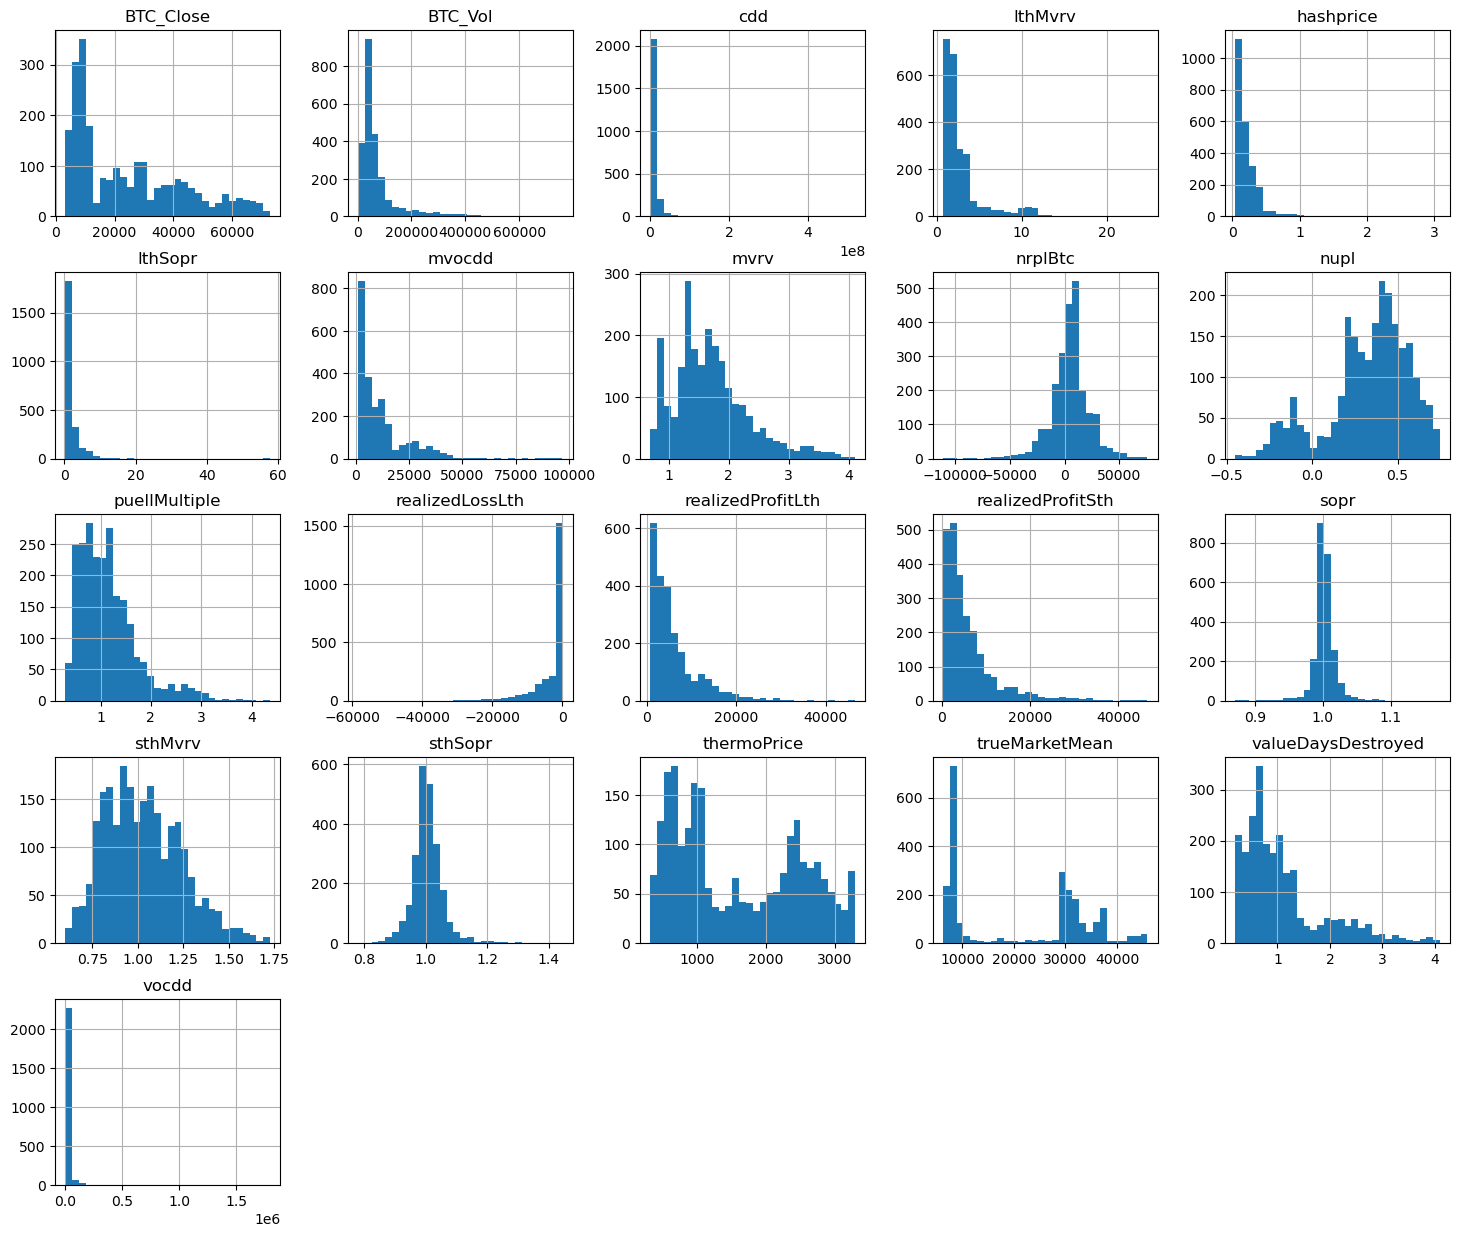

In [40]:
# Distrubcion de las variables 
df_modelo.hist(bins=30, figsize=(18,15))
plt.show()

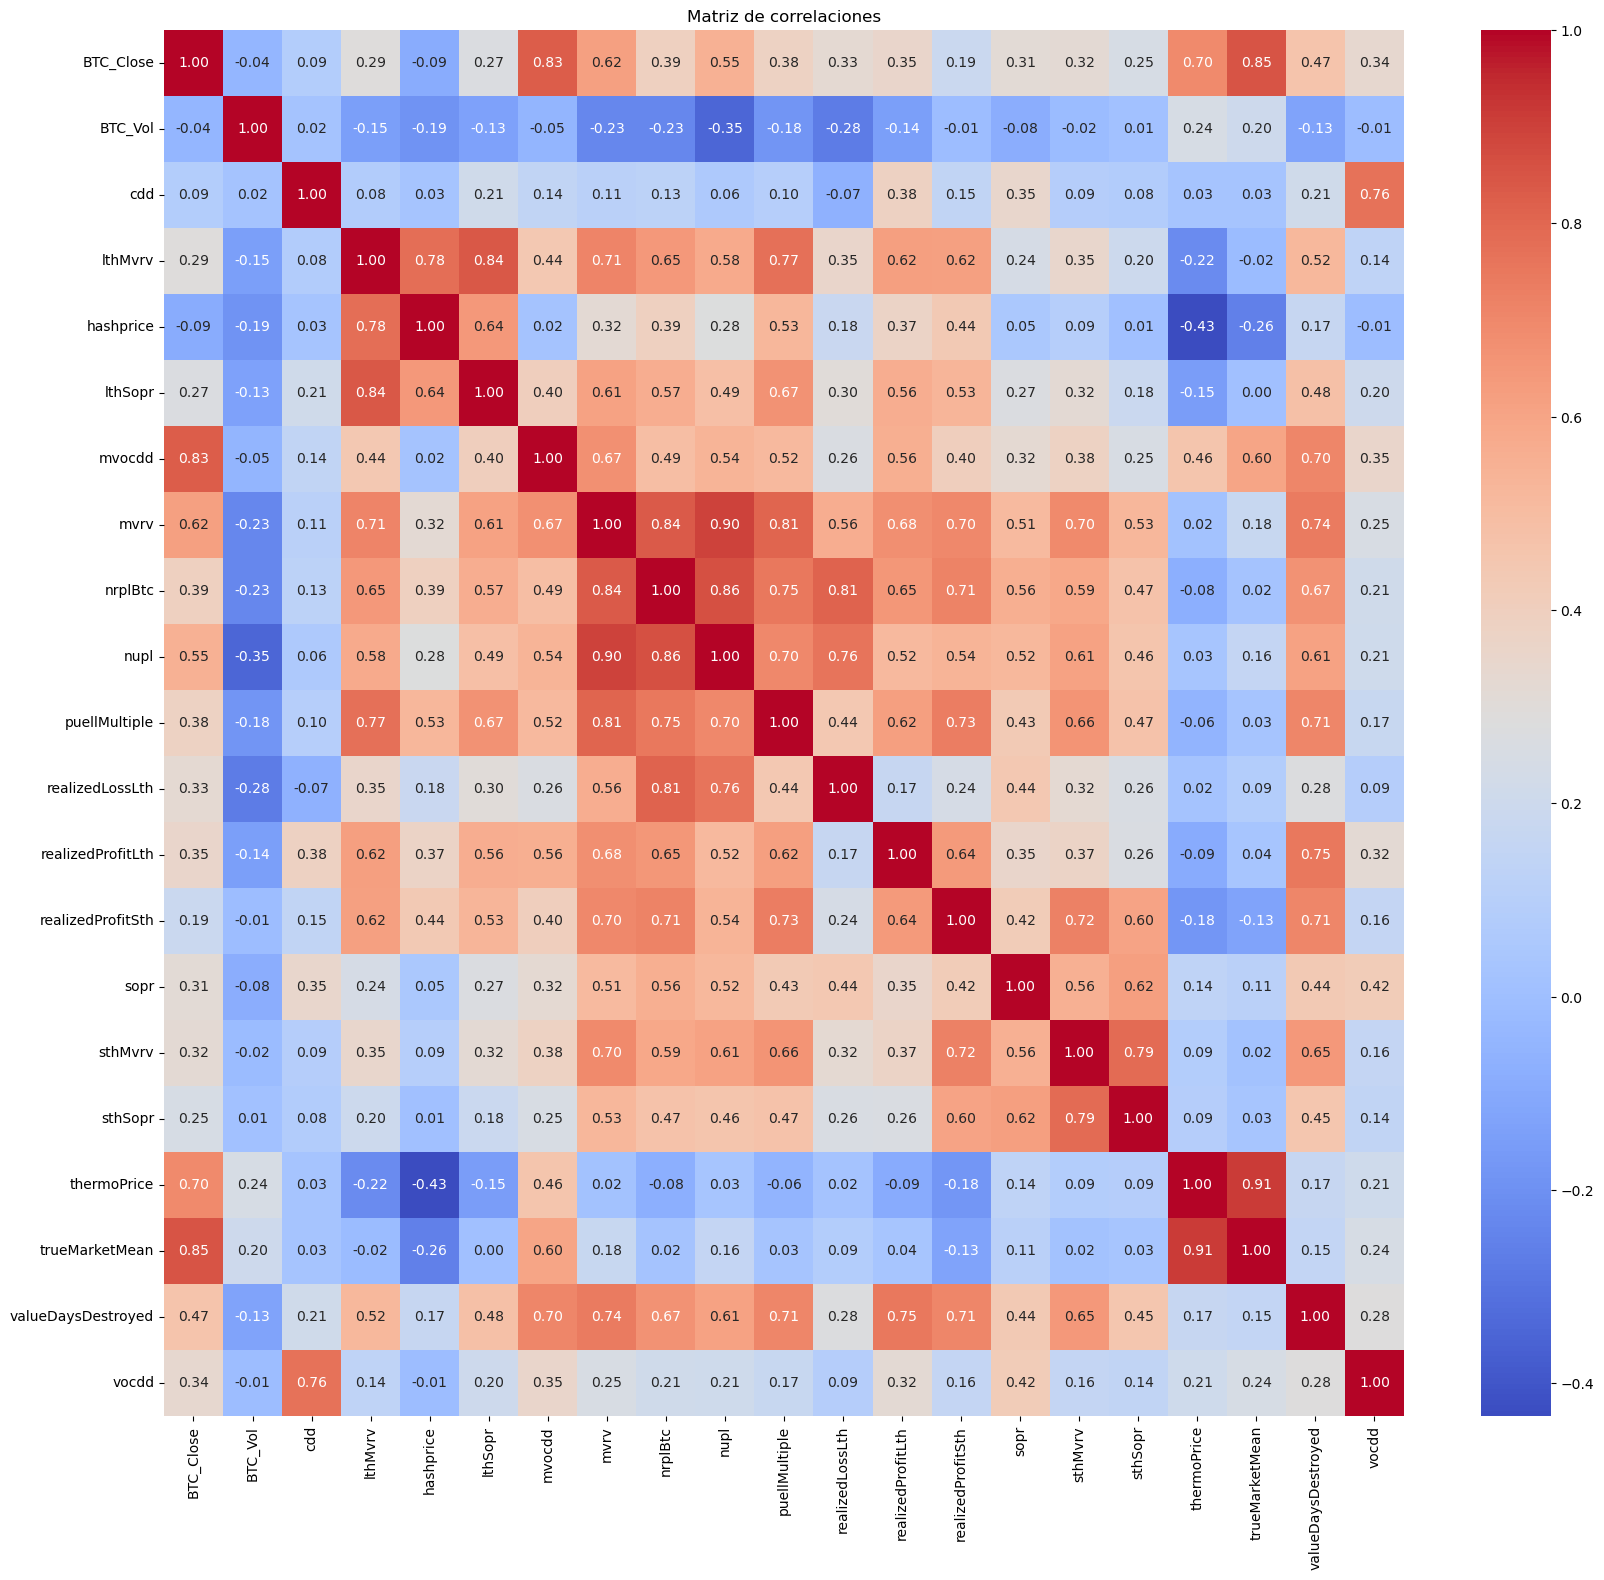

In [41]:
# Mapa de correlacion
plt.figure(figsize=(20,18))
sns.heatmap(df_modelo.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlaciones")
plt.show()

In [42]:
# Eliminar las variables con una alta correlacion entre ellas para no sea redundante
def eliminar_var_alta_corr(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_cols = [col for col in upper.columns if any(upper[col] > threshold)]
    
    # Sobrescribir el DataFrame original
    df.drop(columns=drop_cols, inplace=True)
    return drop_cols

# Aplicar al DataFrame
eliminadas = eliminar_var_alta_corr(df_modelo, threshold=0.9)

print("Columnas eliminadas por alta correlación:", eliminadas)
print("Nuevo shape de df_modelo:", df_modelo.shape)

Columnas eliminadas por alta correlación: ['trueMarketMean']
Nuevo shape de df_modelo: (2373, 20)


In [43]:
# Calcular correlaciones con la variable target
corr_target = df_modelo.corr()['BTC_Close'].sort_values(ascending=False)

# Mostrar listado
print(corr_target)

BTC_Close             1.000000
mvocdd                0.831894
thermoPrice           0.695730
mvrv                  0.615467
nupl                  0.550359
valueDaysDestroyed    0.465730
nrplBtc               0.393979
puellMultiple         0.379466
realizedProfitLth     0.351376
vocdd                 0.338148
realizedLossLth       0.327033
sthMvrv               0.321301
sopr                  0.314778
lthMvrv               0.293524
lthSopr               0.267968
sthSopr               0.248302
realizedProfitSth     0.185794
cdd                   0.085746
BTC_Vol              -0.043316
hashprice            -0.087818
Name: BTC_Close, dtype: float64


In [44]:
# Variables a eliminar según correlación con BTC_Close
irrelevantes = df_modelo.columns[(df_modelo.corr()['BTC_Close'] >= -0.2) & 
                                 (df_modelo.corr()['BTC_Close'] <= 0.2)].tolist()

df_modelo = df_modelo.drop(columns=irrelevantes)
print("Variables eliminadas por baja correlación:", irrelevantes)

Variables eliminadas por baja correlación: ['BTC_Vol', 'cdd', 'hashprice', 'realizedProfitSth']


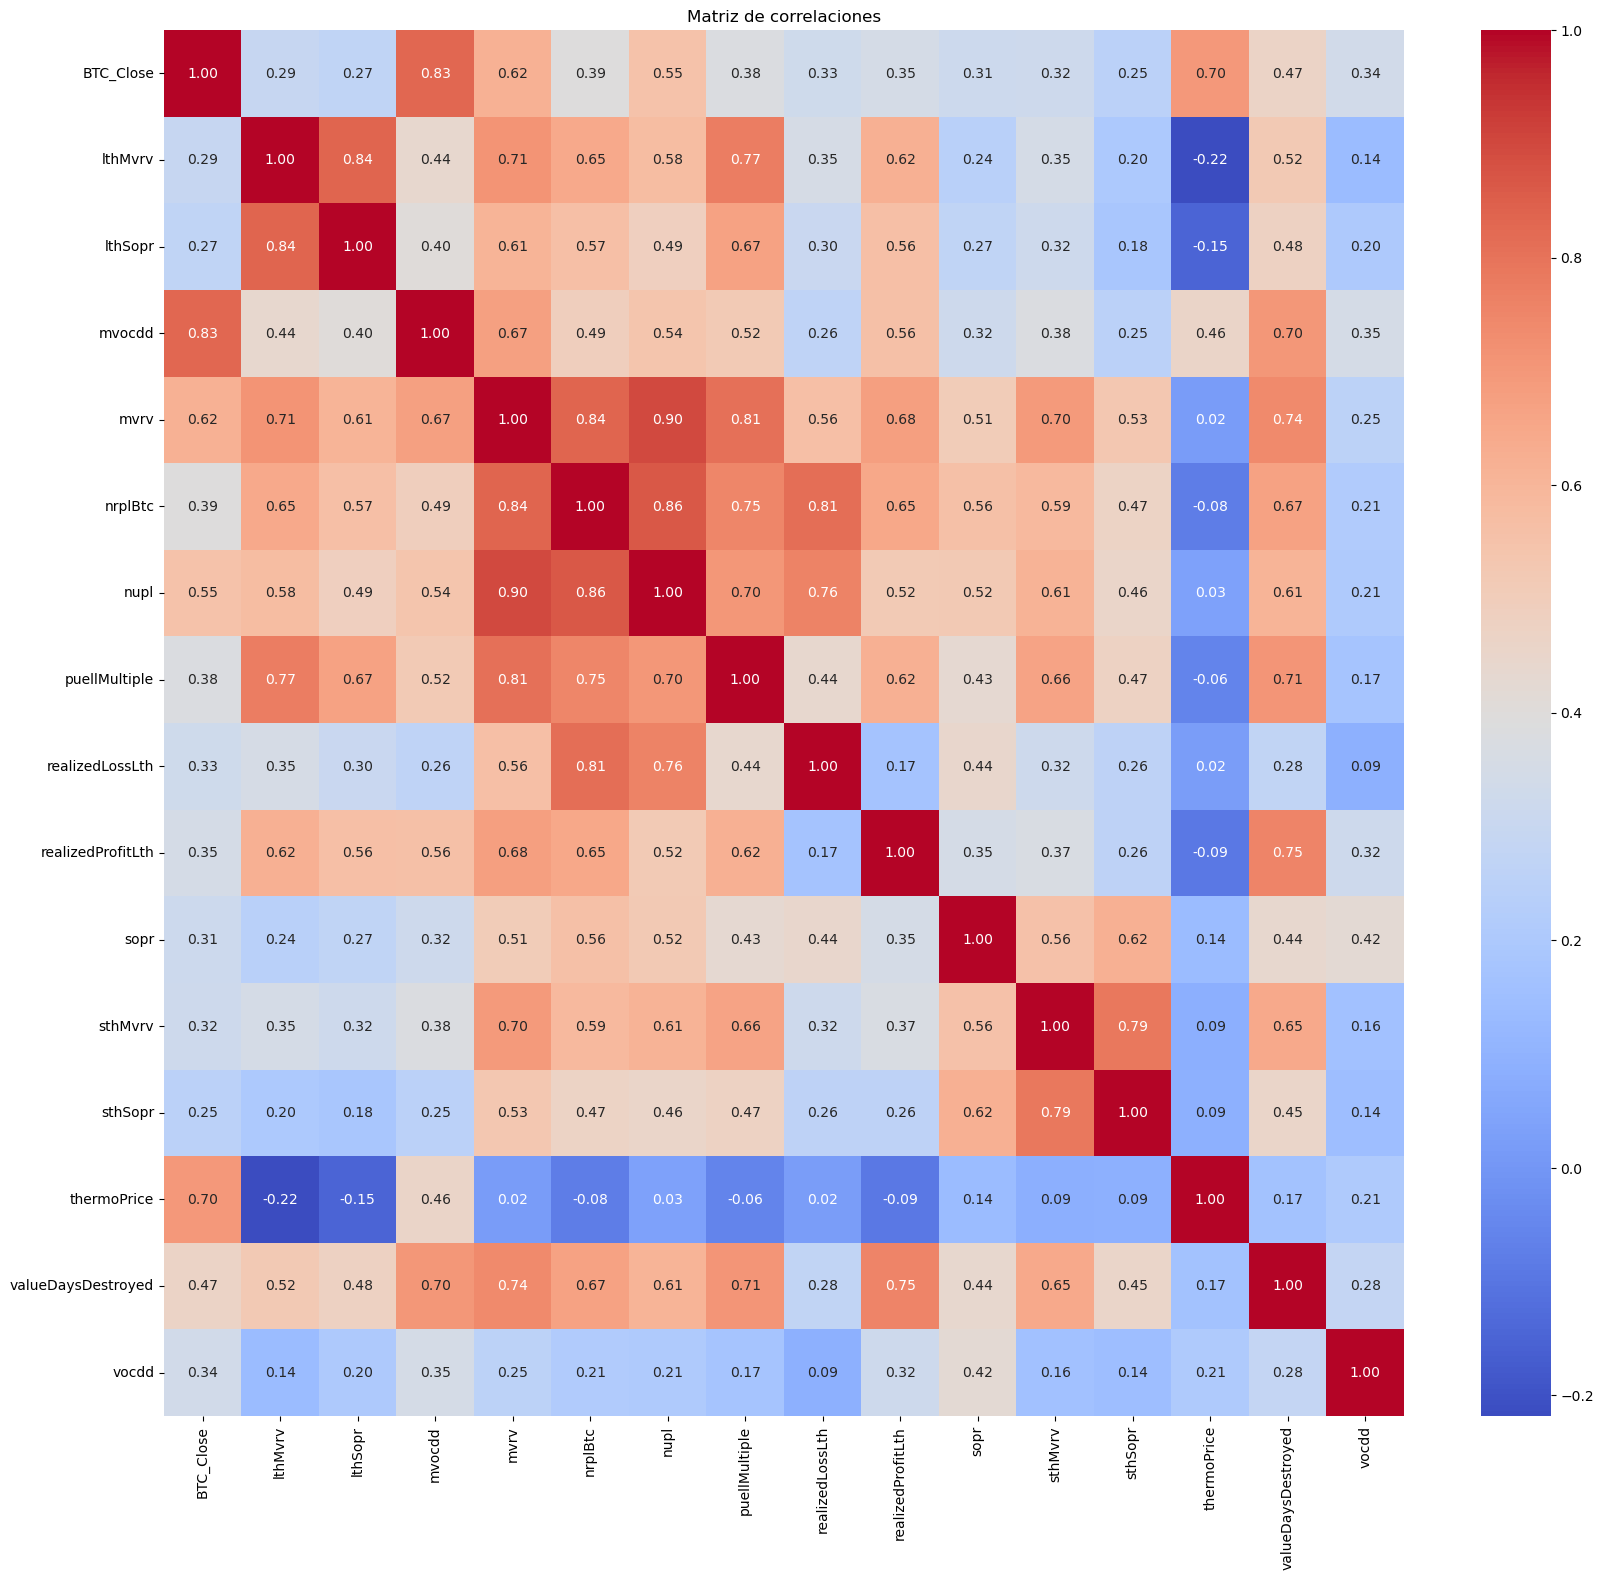

In [45]:
# Mapa de correlacion
plt.figure(figsize=(20,18))
sns.heatmap(df_modelo.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlaciones")
plt.show()

**La información mutua (IM)** entre dos variables aleatorias es un valor no negativo que mide la dependencia entre las variables. Es igual a cero si y sólo si dos variables aleatorias son independientes, y los valores más altos significan una mayor dependencia

In [46]:
# Informacion mutua 
X = df_modelo.drop(columns=['BTC_Close'])
y = df_modelo['BTC_Close']

mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_series)

thermoPrice           2.917026
mvrv                  2.375920
nupl                  2.299151
lthMvrv               2.293218
mvocdd                1.718314
valueDaysDestroyed    1.175354
realizedLossLth       1.019181
nrplBtc               1.006620
sthMvrv               0.962656
puellMultiple         0.787198
lthSopr               0.777521
realizedProfitLth     0.612363
vocdd                 0.545408
sopr                  0.310568
sthSopr               0.250979
dtype: float64


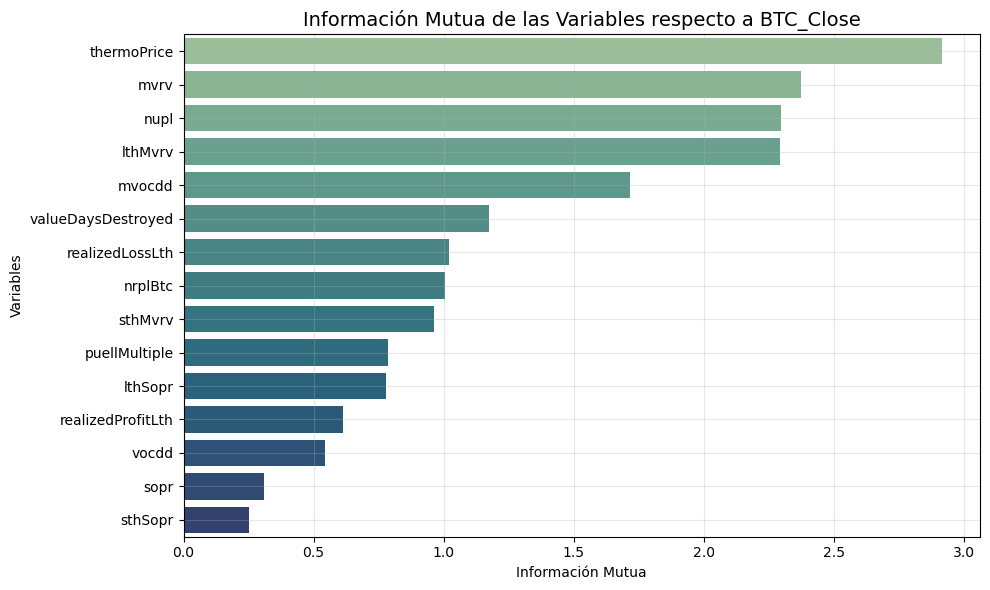

In [47]:
# Gráfico de barras horizontales
plt.figure(figsize=(10, 6))
sns.barplot(
    x=mi_series.values, 
    y=mi_series.index, 
    hue=mi_series.index,      
    palette='crest', 
    dodge=False, 
    legend=False            
)

plt.title('Información Mutua de las Variables respecto a BTC_Close', fontsize=14)
plt.xlabel('Información Mutua')
plt.ylabel('Variables')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [48]:
# Umbral
umbral = 0.5

# Variables a mantener
vars_importantes = mi_series[mi_series >= umbral].index

# Filtrar df_modelo
df_modelo = df_modelo[vars_importantes.tolist() + ['BTC_Close']]

print("Variables conservadas:", list(df_modelo.columns))

Variables conservadas: ['thermoPrice', 'mvrv', 'nupl', 'lthMvrv', 'mvocdd', 'valueDaysDestroyed', 'realizedLossLth', 'nrplBtc', 'sthMvrv', 'puellMultiple', 'lthSopr', 'realizedProfitLth', 'vocdd', 'BTC_Close']


La información mutua mide la dependencia entre dos variables, capturando tanto relaciones lineales como no lineales. En este caso, la MI entre cada variable explicativa (X) y el precio de Bitcoin (BTC_Close). Valores más altos indican mayor dependencia informativa; es decir, esa variable aporta más conocimiento sobre el comportamiento de BTC, MI siempre es no negativa ($𝑀𝐼≥0$), y su magnitud depende de la entropía de las variables.

No existe un umbral de referencia aunque algunos estudios recomiendan normalizar para obtener los valores dentro de una escala para poder compararlas

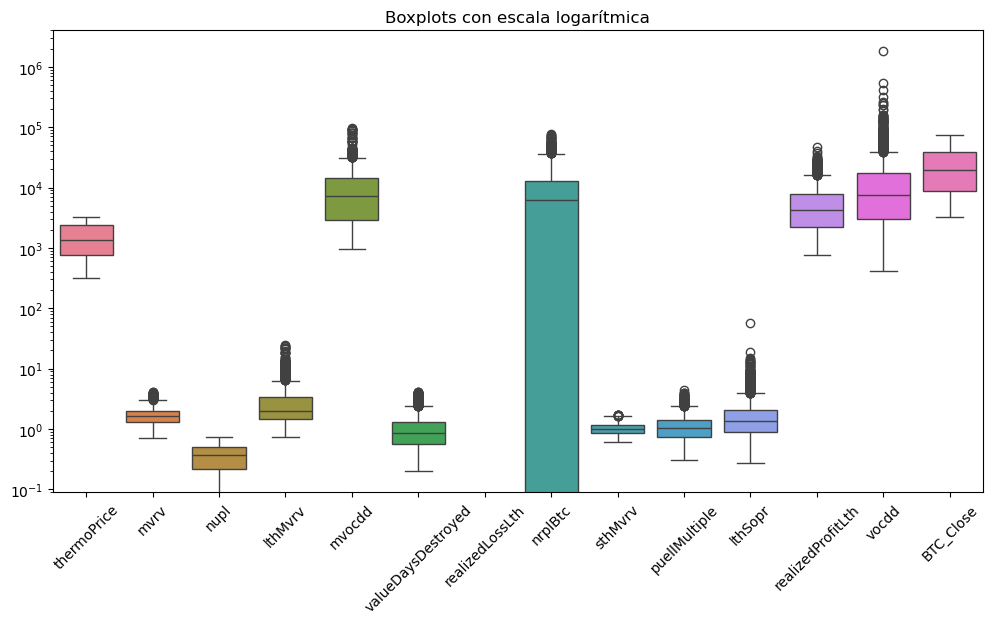

In [49]:
# Visualizacion de los outliers de forma logaritmica
num_cols = df_modelo.select_dtypes(include='number').columns

plt.figure(figsize=(12,6))
sns.boxplot(data=df_modelo[num_cols])
plt.yscale('log') 
plt.xticks(rotation=45)
plt.title('Boxplots con escala logarítmica')
plt.show()

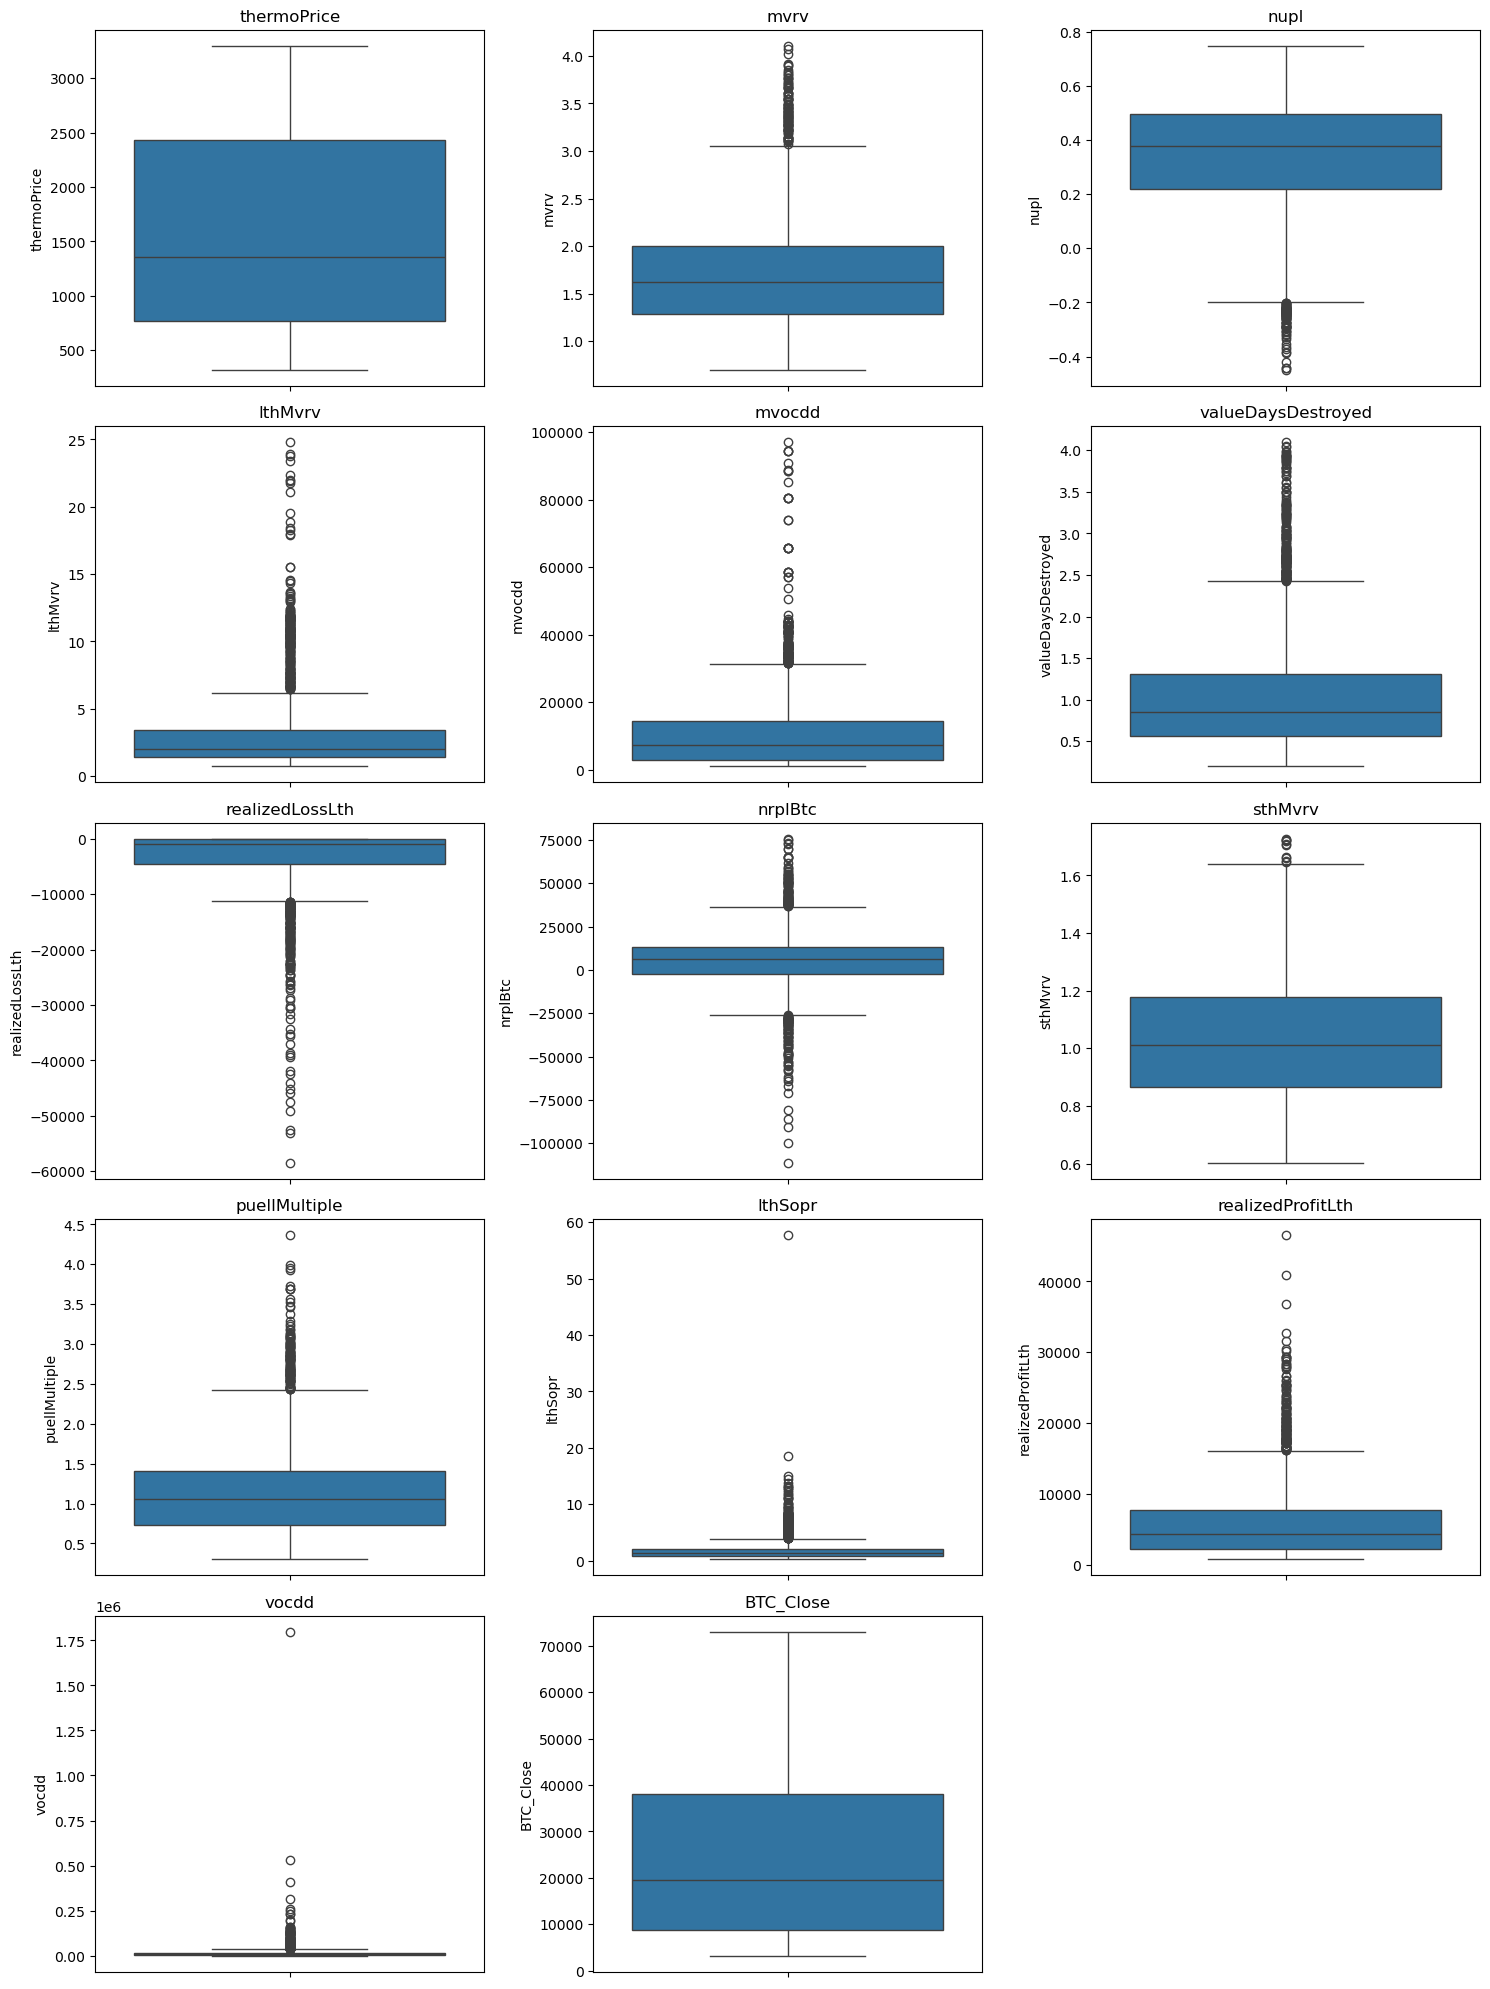

In [50]:
num_cols = df_modelo.select_dtypes(include='number').columns
n_cols = 3  # columnas por fila
n_rows = int(np.ceil(len(num_cols)/n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(y=df_modelo[col], ax=axes[i])
    axes[i].set_title(col)

# Limpiar ejes vacíos si hay subplots sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Seleccion de Variables

## Semilla de reproducibilidad

In [51]:
# Establecer semilla
SEED = 42

## Variables seleccionadas y Estandarizacion

In [52]:
# Variables seleccionadas
variables = ['thermoPrice', 'mvrv', 'nupl', 'lthMvrv', 'mvocdd', 
             'valueDaysDestroyed', 'realizedLossLth', 
             'nrplBtc', 'sthMvrv', 'puellMultiple', 'lthSopr', 'realizedProfitLth', 'vocdd']

target = "BTC_Close"

## Test y train y Crear secuencias

In [53]:
def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps, 0])  
    return np.array(Xs), np.array(ys)

# Definir variables
X = df_modelo[variables]
y = df_modelo[[target]]   


# Separar en train (75%), val (10%), test (15%)

n_total = len(X)

n_train = int(n_total * 0.75)
n_val   = int(n_total * 0.10)
n_test  = n_total - (n_train + n_val)  

# Cortes respetando orden temporal
X_train_raw = X.iloc[:n_train]
y_train_raw = y.iloc[:n_train]

X_val_raw = X.iloc[n_train:n_train+n_val]
y_val_raw = y.iloc[n_train:n_train+n_val]

X_test_raw = X.iloc[n_train+n_val:]
y_test_raw = y.iloc[n_train+n_val:]

print(f"Tamaños -> Train: {len(X_train_raw)}, Val: {len(X_val_raw)}, Test: {len(X_test_raw)}")


# Escalar datos (solo fit en train)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train_raw)
X_val   = scaler_X.transform(X_val_raw)
X_test  = scaler_X.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw)
y_val   = scaler_y.transform(y_val_raw)
y_test  = scaler_y.transform(y_test_raw)


# Crear secuencias para cada time_step
time_steps = [7, 15, 30]
sequences = {}

for t in time_steps:
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, t)
    X_val_seq, y_val_seq     = create_sequences(X_val, y_val, t)
    X_test_seq, y_test_seq   = create_sequences(X_test, y_test, t)

    sequences[t] = {
        "X_train": X_train_seq,
        "y_train": y_train_seq,
        "X_val": X_val_seq,
        "y_val": y_val_seq,
        "X_test": X_test_seq,
        "y_test": y_test_seq,
        "scaler_X": scaler_X,
        "scaler_y": scaler_y
    }

print("Datos divididos en 75% train, 15% validación y 10% test")
print("Accede a sequences[time_step] para obtener cada conjunto")

Tamaños -> Train: 1779, Val: 237, Test: 357
Datos divididos en 75% train, 15% validación y 10% test
Accede a sequences[time_step] para obtener cada conjunto


## Hiperparametros a valorar 

In [54]:
# Hiperparámetros a probar
num_layers_list = [1, 2]                     # número de capas
units_list = [32, 64]                        # neuronas por capa
activations_list = ["elu", "relu", "selu"]   # funciones de activación
learning_rates = [0.01, 0.001, 0.0005]       # tasas de aprendizaje
optimizers_list = ["adam", "rmsprop"]        # optimizadores
batch_sizes = [32, 64, 128]                  # tamaños de batch
epochs = 10                                  # número de épocas

## Establecer un Early Stopping para despues optimizar los resultados

In [55]:
# EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Estudio RNN nuevo

## Busqueda Hiperparametros

In [ ]:
# Semillas para reproducibilidad 
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

for time in time_steps:
    resultados = []

    data = sequences[time]  # Trabajamos con el diccionario único
    X_train_seq = data["X_train"]
    y_train_seq = data["y_train"]
    X_val_seq   = data["X_val"]
    y_val_seq   = data["y_val"]

    # Recorremos todas las combinaciones de hiperparámetros
    for num_layers in num_layers_list:
        for units in units_list:
            for activation in activations_list:
                for lr in learning_rates:
                    for opt_name in optimizers_list:
                        for batch in batch_sizes:
                            print(f"Entrenando: capas={num_layers}, units={units}, act={activation}, lr={lr}, opt={opt_name}, batch={batch}, time_step={time}")

                            # Crear modelo RNN
                            model = keras.Sequential()
                            for i in range(num_layers):
                                model.add(layers.SimpleRNN(
                                    units,
                                    activation=activation,
                                    return_sequences=(i < num_layers - 1)
                                ))
                            model.add(layers.Dense(1, activation="linear"))

                            # Optimizador
                            if opt_name == "adam":
                                optimizer = keras.optimizers.Adam(learning_rate=lr)
                            elif opt_name == "rmsprop":
                                optimizer = keras.optimizers.RMSprop(learning_rate=lr)

                            model.compile(optimizer=optimizer, loss="mse")

                            # Entrenar
                            model.fit(
                                X_train_seq, y_train_seq,
                                validation_data=(X_val_seq, y_val_seq),
                                epochs=epochs, batch_size=batch, verbose=0
                            )

                            # Predicciones
                            y_val_pred = model.predict(X_val_seq, verbose=0)

                            # Métricas
                            mae = mean_absolute_error(y_val_seq, y_val_pred)
                            rmse = np.sqrt(mean_squared_error(y_val_seq, y_val_pred))
                            mape = mean_absolute_percentage_error(y_val_seq, y_val_pred) * 100

                            # Guardar resultado
                            resultados.append({
                                "time_step": time,
                                "capas": num_layers,
                                "units": units,
                                "activation": activation,
                                "lr": lr,
                                "opt": opt_name,
                                "batch": batch,
                                "MAE": mae,
                                "RMSE": rmse,
                                "MAPE": mape
                            })

    # Guardar resultados de este time_step
    df_resultados_rnn = pd.DataFrame(resultados)
    df_resultados_rnn = df_resultados_rnn.sort_values("MAPE", ascending=True)
    df_resultados_rnn.to_csv(f"resultados_rnn_time{time}_epoch{epochs}.csv", index=False)
    print(f"Guardado resultados para time_step={time}")

## Optimizar los modelos con los mejores parametros 

In [ ]:
# Semillas para reproducibilidad 
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Crear carpeta para guardar historiales
os.makedirs("historia_RNN", exist_ok=True)


# Cargar y unir top-5 de cada CSV inicial

files = [
    "resultados_rnn_time7_epoch10.csv",
    "resultados_rnn_time15_epoch10.csv",
    "resultados_rnn_time30_epoch10.csv"
]

dfs = []
for file in files:
    df = pd.read_csv(file)
    df = df.sort_values("MAE", ascending=True).head(5)  # top-5
    dfs.append(df)

# Unir y ordenar 
df_models = pd.concat(dfs, ignore_index=True)
df_models = df_models.sort_values(["MAE", "RMSE"], ascending=[True, True]).reset_index(drop=True)

# Identificador único 
df_models.insert(0, "modelo_idx", df_models.index + 1)


# Re-entrenar cada modelo
resultados_finales = []

for _, row in df_models.iterrows():
    params = {
        "time_step": int(row["time_step"]),
        "capas": int(row["capas"]),
        "units": int(row["units"]),
        "activation": row["activation"],
        "lr": float(row["lr"]),
        "opt": row["opt"],
        "batch": int(row["batch"])
    }

    print(f"\n🔹 Re-entrenando modelo {row['modelo_idx']} con: {params}")

    # Seleccionar datos según ventana temporal
    data = sequences[params["time_step"]]
    X_train_seq = data["X_train"]
    y_train_seq = data["y_train"]
    X_val_seq   = data["X_val"]
    y_val_seq   = data["y_val"]
    X_test_seq  = data["X_test"]
    y_test_seq  = data["y_test"]

    # Crear modelo
    model = keras.Sequential()
    for i in range(params["capas"]):
        model.add(layers.SimpleRNN(
            params["units"],
            activation=params["activation"],
            return_sequences=(i < params["capas"] - 1)
        ))
    model.add(layers.Dense(1, activation="linear"))

    # Optimizador
    if params["opt"] == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=params["lr"])
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=params["lr"])

    model.compile(optimizer=optimizer, loss="mse")

    # Entrenar
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=100,
        batch_size=params["batch"],
        verbose=0,
        callbacks=[early_stopping]
    )

    # Guardar historial
    history_df = pd.DataFrame(history.history)
    hist_file = (
        f"historia_RNN/historia_RNN_modelo{row['modelo_idx']}"
        f"_time{params['time_step']}_capas{params['capas']}"
        f"_units{params['units']}_act{params['activation']}"
        f"_lr{params['lr']}_opt{params['opt']}_batch{params['batch']}_ES5.csv"
    )
    history_df.to_csv(hist_file, index=False)

    # Validación 
    y_val_pred = model.predict(X_val_seq, verbose=0)
    mae_val  = mean_absolute_error(y_val_seq, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val_seq, y_val_pred))
    mape_val = mean_absolute_percentage_error(y_val_seq, y_val_pred) * 100

    # Test 
    y_test_pred = model.predict(X_test_seq, verbose=0)
    mae_test  = mean_absolute_error(y_test_seq, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test_seq, y_test_pred))
    mape_test = mean_absolute_percentage_error(y_test_seq, y_test_pred) * 100

    # Guardar métricas
    resultados_finales.append({
        "modelo_idx": int(row["modelo_idx"]),
        "time_step": params["time_step"],
        "capas": params["capas"],
        "units": params["units"],
        "activation": params["activation"],
        "lr": params["lr"],
        "opt": params["opt"],
        "batch": params["batch"],
        "MAE_val": mae_val,
        "RMSE_val": rmse_val,
        "MAPE_val": mape_val,
        "MAE_test": mae_test,
        "RMSE_test": rmse_test,
        "MAPE_test": mape_test

    })

    K.clear_session()

# Guardar resultados
df_finales = pd.DataFrame(resultados_finales).sort_values("MAE_test", ascending=True)
print("\nResultados finales RNN (100 epochs + EarlyStopping 5):\n", df_finales)

df_finales.to_csv("resultados_top15_rnn_epoch100_ES 5.csv", index=False)

# Estudio LSTM Nuevo

## Busqueda Hiperparametros

In [ ]:
# Semillas para reproducibilidad 
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

for time in time_steps:
    resultados = []

    data = sequences[time]  # Trabajamos con el diccionario único
    X_train_seq = data["X_train"]
    y_train_seq = data["y_train"]
    X_val_seq   = data["X_val"]
    y_val_seq   = data["y_val"]

    # Recorremos todas las combinaciones de hiperparámetros
    for num_layers in num_layers_list:
        for units in units_list:
            for activation in activations_list:
                for lr in learning_rates:
                    for opt_name in optimizers_list:
                        for batch in batch_sizes:
                            print(f"Entrenando: capas={num_layers}, units={units}, act={activation}, lr={lr}, opt={opt_name}, batch={batch}, time_step={time}")

                            # Crear modelo RNN
                            model = keras.Sequential()
                            for i in range(num_layers):
                                model.add(layers.LSTM(
                                    units,
                                    activation=activation,
                                    return_sequences=(i < num_layers - 1)
                                ))
                            model.add(layers.Dense(1, activation="linear"))

                            # Optimizador
                            if opt_name == "adam":
                                optimizer = keras.optimizers.Adam(learning_rate=lr)
                            elif opt_name == "rmsprop":
                                optimizer = keras.optimizers.RMSprop(learning_rate=lr)

                            model.compile(optimizer=optimizer, loss="mse")

                            # Entrenar
                            model.fit(
                                X_train_seq, y_train_seq,
                                validation_data=(X_val_seq, y_val_seq),
                                epochs=epochs, batch_size=batch, verbose=0
                            )

                            # Predicciones
                            y_val_pred = model.predict(X_val_seq, verbose=0)

                            # Métricas
                            mae = mean_absolute_error(y_val_seq, y_val_pred)
                            rmse = np.sqrt(mean_squared_error(y_val_seq, y_val_pred))
                            mape = mean_absolute_percentage_error(y_val_seq, y_val_pred) * 100

                            # Guardar resultado
                            resultados.append({
                                "time_step": time,
                                "capas": num_layers,
                                "units": units,
                                "activation": activation,
                                "lr": lr,
                                "opt": opt_name,
                                "batch": batch,
                                "MAE": mae,
                                "RMSE": rmse,
                                "MAPE": mape
                            })

    # Guardar resultados de este time_step
    df_resultados_rnn = pd.DataFrame(resultados)
    df_resultados_rnn = df_resultados_rnn.sort_values("MAPE", ascending=True)
    df_resultados_rnn.to_csv(f"resultados_lstm_time{time}_epoch{epochs}.csv", index=False)
    print(f"Guardado resultados para time_step={time}")

## Optimizar los modelos con los mejores parametros 

In [ ]:
# Semillas para reproducibilidad 
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Crear carpeta para guardar historiales
os.makedirs("historia_LSTM", exist_ok=True)

# Cargar y unir top-5 de cada CSV inicial
files = [
    "resultados_lstm_time7_epoch10.csv",
    "resultados_lstm_time15_epoch10.csv",
    "resultados_lstm_time30_epoch10.csv"
]

dfs = []
for file in files:
    df = pd.read_csv(file)
    df = df.sort_values("MAE", ascending=True).head(5)  # top-5
    dfs.append(df)

# Unir y ordenar globalmente
df_models = pd.concat(dfs, ignore_index=True)
df_models = df_models.sort_values(["MAE", "RMSE"], ascending=[True, True]).reset_index(drop=True)

# Identificador único 1..15
df_models.insert(0, "modelo_idx", df_models.index + 1)


# Re-entrenar cada modelo
resultados_finales = []

for _, row in df_models.iterrows():
    params = {
        "time_step": int(row["time_step"]),
        "capas": int(row["capas"]),
        "units": int(row["units"]),
        "activation": row["activation"],
        "lr": float(row["lr"]),
        "opt": row["opt"],
        "batch": int(row["batch"])
    }

    print(f"\n🔹 Re-entrenando modelo {row['modelo_idx']} con: {params}")

    # Seleccionar datos según ventana temporal
    data = sequences[params["time_step"]]
    X_train_seq = data["X_train"]
    y_train_seq = data["y_train"]
    X_val_seq   = data["X_val"]
    y_val_seq   = data["y_val"]
    X_test_seq  = data["X_test"]
    y_test_seq  = data["y_test"]

    # Crear modelo
    model = keras.Sequential()
    for i in range(params["capas"]):
        model.add(layers.LSTM(
            params["units"],
            activation=params["activation"],
            return_sequences=(i < params["capas"] - 1)
        ))
    model.add(layers.Dense(1, activation="linear"))

    # Optimizador
    if params["opt"] == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=params["lr"])
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=params["lr"])

    model.compile(optimizer=optimizer, loss="mse")

    # Entrenar
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=100,
        batch_size=params["batch"],
        verbose=0,
        callbacks=[early_stopping]
    )

    # Guardar historial
    history_df = pd.DataFrame(history.history)
    hist_file = (
        f"historia_LSTM/historia_LSTM_modelo{row['modelo_idx']}"
        f"_time{params['time_step']}_capas{params['capas']}"
        f"_units{params['units']}_act{params['activation']}"
        f"_lr{params['lr']}_opt{params['opt']}_batch{params['batch']}_ES5.csv"
    )
    history_df.to_csv(hist_file, index=False)

    # Validación
    y_val_pred = model.predict(X_val_seq, verbose=0)
    mae_val  = mean_absolute_error(y_val_seq, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val_seq, y_val_pred))
    mape_val = mean_absolute_percentage_error(y_val_seq, y_val_pred) * 100

    # Test
    y_test_pred = model.predict(X_test_seq, verbose=0)
    mae_test  = mean_absolute_error(y_test_seq, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test_seq, y_test_pred))
    mape_test = mean_absolute_percentage_error(y_test_seq, y_test_pred) * 100

    # Guardar métricas
    resultados_finales.append({
        "modelo_idx": int(row["modelo_idx"]),
        "time_step": params["time_step"],
        "capas": params["capas"],
        "units": params["units"],
        "activation": params["activation"],
        "lr": params["lr"],
        "opt": params["opt"],
        "batch": params["batch"],
        "MAE_val": mae_val,
        "RMSE_val": rmse_val,
        "MAPE_val": mape_val,
        "MAE_test": mae_test,
        "RMSE_test": rmse_test,
        "MAPE_test": mape_test,
    })

    K.clear_session()


# Guardar resultados
df_finales = pd.DataFrame(resultados_finales).sort_values("MAE_test", ascending=True)
print("\nResultados finales LSTM (100 epochs + EarlyStopping 5):\n", df_finales)

df_finales.to_csv("resultados_top15_lstm_epoch100_ES 5.csv", index=False)

# Estudio con GRU nuevo

## Busqueda Hiperparametros

In [ ]:
# Semillas para reproducibilidad 
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

for time in time_steps:
    resultados = []

    data = sequences[time]  # Trabajamos con el diccionario único
    X_train_seq = data["X_train"]
    y_train_seq = data["y_train"]
    X_val_seq   = data["X_val"]
    y_val_seq   = data["y_val"]

    # Recorremos todas las combinaciones de hiperparámetros
    for num_layers in num_layers_list:
        for units in units_list:
            for activation in activations_list:
                for lr in learning_rates:
                    for opt_name in optimizers_list:
                        for batch in batch_sizes:
                            print(f"Entrenando: capas={num_layers}, units={units}, act={activation}, lr={lr}, opt={opt_name}, batch={batch}, time_step={time}")

                            # Crear modelo RNN
                            model = keras.Sequential()
                            for i in range(num_layers):
                                model.add(layers.GRU(
                                    units,
                                    activation=activation,
                                    return_sequences=(i < num_layers - 1)
                                ))
                            model.add(layers.Dense(1, activation="linear"))

                            # Optimizador
                            if opt_name == "adam":
                                optimizer = keras.optimizers.Adam(learning_rate=lr)
                            elif opt_name == "rmsprop":
                                optimizer = keras.optimizers.RMSprop(learning_rate=lr)

                            model.compile(optimizer=optimizer, loss="mse")

                            # Entrenar
                            model.fit(
                                X_train_seq, y_train_seq,
                                validation_data=(X_val_seq, y_val_seq),
                                epochs=epochs, batch_size=batch, verbose=0
                            )

                            # Predicciones
                            y_val_pred = model.predict(X_val_seq, verbose=0)

                            # Métricas
                            mae = mean_absolute_error(y_val_seq, y_val_pred)
                            rmse = np.sqrt(mean_squared_error(y_val_seq, y_val_pred))
                            mape = mean_absolute_percentage_error(y_val_seq, y_val_pred) * 100
                            r2 = r2_score(y_val_seq, y_val_pred)

                            # Guardar resultado
                            resultados.append({
                                "time_step": time,
                                "capas": num_layers,
                                "units": units,
                                "activation": activation,
                                "lr": lr,
                                "opt": opt_name,
                                "batch": batch,
                                "MAE": mae,
                                "RMSE": rmse,
                                "MAPE": mape,
                                "R2": r2
                            })

    # Guardar resultados de este time_step
    df_resultados_rnn = pd.DataFrame(resultados)
    df_resultados_rnn = df_resultados_rnn.sort_values("MAPE", ascending=True)
    df_resultados_rnn.to_csv(f"resultados_gru_time{time}_epoch{epochs}.csv", index=False)
    print(f"Guardado resultados para time_step={time}")

## Optimizar los modelos con los mejores parametros 

In [ ]:
# Semillas para reproducibilidad 
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Crear carpeta para guardar historiales
os.makedirs("historia_GRU", exist_ok=True)

# Cargar y unir top-5 de cada CSV inicial

files = [
    "resultados_gru_time7_epoch10.csv",
    "resultados_gru_time15_epoch10.csv",
    "resultados_gru_time30_epoch10.csv"
]

dfs = []
for file in files:
    df = pd.read_csv(file)
    df = df.sort_values("MAE", ascending=True).head(5)  
    dfs.append(df)

# Unir y ordenar 
df_models = pd.concat(dfs, ignore_index=True)
df_models = df_models.sort_values(["MAE", "RMSE"], ascending=[True, True]).reset_index(drop=True)

# Identificador único
df_models.insert(0, "modelo_idx", df_models.index + 1)


# Re-entrenar cada modelo

resultados_finales = []

for _, row in df_models.iterrows():
    params = {
        "time_step": int(row["time_step"]),
        "capas": int(row["capas"]),
        "units": int(row["units"]),
        "activation": row["activation"],
        "lr": float(row["lr"]),
        "opt": row["opt"],
        "batch": int(row["batch"])
    }

    print(f"\n🔹 Re-entrenando modelo {row['modelo_idx']} con: {params}")

    # Seleccionar datos según ventana temporal
    data = sequences[params["time_step"]]
    X_train_seq = data["X_train"]
    y_train_seq = data["y_train"]
    X_val_seq   = data["X_val"]
    y_val_seq   = data["y_val"]
    X_test_seq  = data["X_test"]
    y_test_seq  = data["y_test"]

    # Crear modelo
    model = keras.Sequential()
    for i in range(params["capas"]):
        model.add(layers.GRU(
            params["units"],
            activation=params["activation"],
            return_sequences=(i < params["capas"] - 1)
        ))
    model.add(layers.Dense(1, activation="linear"))

    # Optimizador
    if params["opt"] == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=params["lr"])
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=params["lr"])

    model.compile(optimizer=optimizer, loss="mse")

    # Entrenar
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=100,
        batch_size=params["batch"],
        verbose=0,
        callbacks=[early_stopping]
    )

    # Guardar historial
    history_df = pd.DataFrame(history.history)
    hist_file = (
        f"historia_GRU/historia_GRU_modelo{row['modelo_idx']}"
        f"_time{params['time_step']}_capas{params['capas']}"
        f"_units{params['units']}_act{params['activation']}"
        f"_lr{params['lr']}_opt{params['opt']}_batch{params['batch']}_ES5.csv"
    )
    history_df.to_csv(hist_file, index=False)

    
    # Validación 
    y_val_pred = model.predict(X_val_seq, verbose=0)
    mae_val  = mean_absolute_error(y_val_seq, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val_seq, y_val_pred))
    mape_val = mean_absolute_percentage_error(y_val_seq, y_val_pred) * 100

    # Test
    y_test_pred = model.predict(X_test_seq, verbose=0)
    mae_test  = mean_absolute_error(y_test_seq, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test_seq, y_test_pred))
    mape_test = mean_absolute_percentage_error(y_test_seq, y_test_pred) * 100

    # Guardar métricas
    resultados_finales.append({
        "modelo_idx": int(row["modelo_idx"]),
        "time_step": params["time_step"],
        "capas": params["capas"],
        "units": params["units"],
        "activation": params["activation"],
        "lr": params["lr"],
        "opt": params["opt"],
        "batch": params["batch"],
        "MAE_val": mae_val,
        "RMSE_val": rmse_val,
        "MAPE_val": mape_val,
        "MAE_test": mae_test,
        "RMSE_test": rmse_test,
        "MAPE_test": mape_test
    })

    K.clear_session()

# Guardar resultados

df_finales = pd.DataFrame(resultados_finales).sort_values("MAE_test", ascending=True)
print("\nResultados finales GRU (100 epochs + EarlyStopping 5):\n", df_finales)

df_finales.to_csv("resultados_top15_gru_epoch100_ES 5.csv", index=False)

# Comparativas

## Tablas Hiperparametros Todos

In [56]:
def generar_tabla_1(arch_name, files, title, output_file):
    """
    Genera una tabla unificada de top-5 modelos por ventana (7,15,30) para la arquitectura dada.
    IDs únicos globales (1..15), ordenados por MAE.
    Además guarda la tabla como imagen (PNG).
    """
    dfs = []
    for file in files:
        df = pd.read_csv(file).head(5)  # coger solo los 5 primeros
        df["modelo"] = arch_name
        dfs.append(df)

    # Unir todo
    df_all = pd.concat(dfs, ignore_index=True)

    # Seleccionar columnas de interés
    cols = ["modelo","time_step","capas","units","activation","lr","opt","batch","MAE","RMSE","MAPE"]
    df_all = df_all[cols]

    # Redondear métricas
    for col in ["MAE","RMSE","MAPE"]:
        df_all[col] = df_all[col].round(3)

    # Ordenar por MAE y añadir ID único global
    df_all = df_all.sort_values(["MAE", "RMSE"], ascending=[True, True]).reset_index(drop=True)
    df_all.insert(0, "Modelo idx", df_all.index + 1)

    # Crear tabla como imagen
    fig, ax = plt.subplots(figsize=(12,4))
    ax.axis('off')
    tabla = ax.table(cellText=df_all.values,
                     colLabels=df_all.columns,
                     loc='center')
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(9)
    tabla.scale(1.2, 1.2)

    # Título
    plt.title(title, fontsize=12, pad=20)

    # Guardar como PNG
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

    return df_all

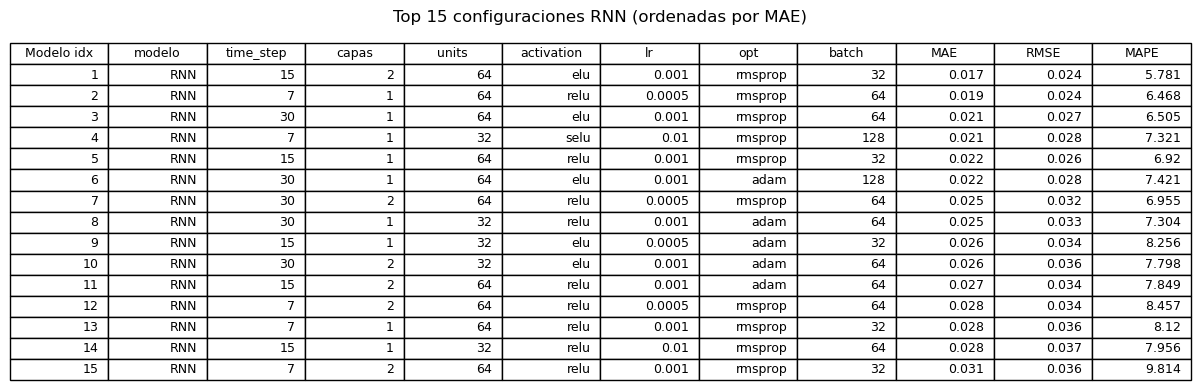

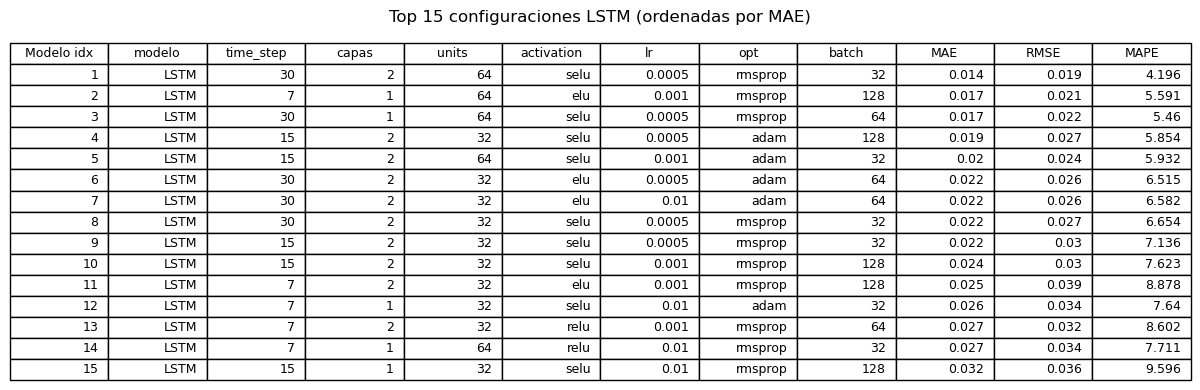

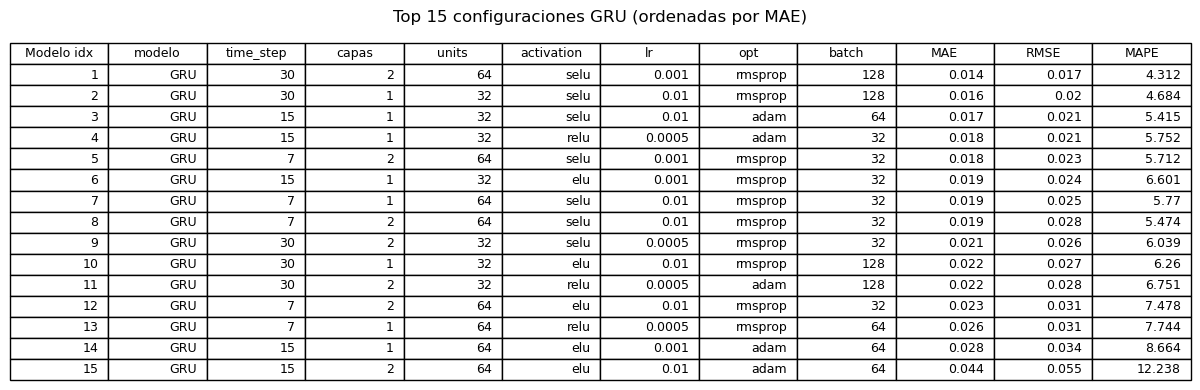

In [57]:
# Archivos RNN
rnn_files = [
    "resultados_rnn_time7_epoch10.csv",
    "resultados_rnn_time15_epoch10.csv",
    "resultados_rnn_time30_epoch10.csv"
]
tabla_rnn = generar_tabla_1("RNN", rnn_files, "Top 15 configuraciones RNN (ordenadas por MAE)", "tabla_rnn.png")


# Archivos LSTM
lstm_files = [
    "resultados_lstm_time7_epoch10.csv",
    "resultados_lstm_time15_epoch10.csv",
    "resultados_lstm_time30_epoch10.csv"
]
tabla_lstm = generar_tabla_1("LSTM", lstm_files, "Top 15 configuraciones LSTM (ordenadas por MAE)", "tabla_lstm.png")


# Archivos GRU
gru_files = [
    "resultados_gru_time7_epoch10.csv",
    "resultados_gru_time15_epoch10.csv",
    "resultados_gru_time30_epoch10.csv"
]
tabla_gru = generar_tabla_1("GRU", gru_files, "Top 15 configuraciones GRU (ordenadas por MAE)", "tabla_gru.png")


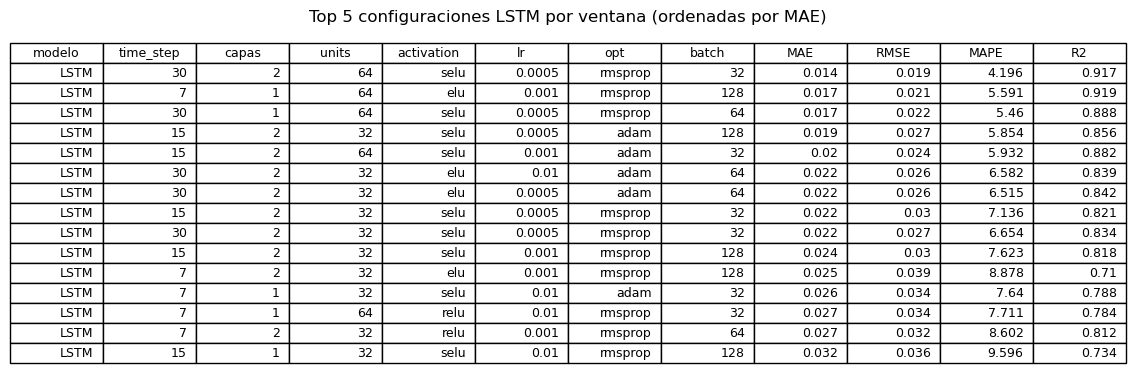

In [59]:
# Archivos
files = [
    ("LSTM", "resultados_lstm_time7_epoch10.csv"),
    ("LSTM", "resultados_lstm_time15_epoch10.csv"),
    ("LSTM", "resultados_lstm_time30_epoch10.csv")
]

# Cargar y unir
dfs = []
for label, file in files:
    df = pd.read_csv(file).head(5)  # coger solo los 5 primeros
    df["modelo"] = label            # añadir columna para identificar la ventana
    dfs.append(df)

# Unir en un solo DataFrame
df_all = pd.concat(dfs, ignore_index=True)

# Seleccionar columnas de interés
cols = ["modelo","time_step","capas","units","activation","lr","opt","batch","MAE","RMSE","MAPE","R2"]
df_all = df_all[cols]

# Redondear métricas
for col in ["MAE","RMSE","MAPE","R2"]:
    df_all[col] = df_all[col].round(3)

# Ordenar por MAE
df_all = df_all.sort_values("MAE").reset_index(drop=True)

# Crear tabla como imagen
fig, ax = plt.subplots(figsize=(12,4))
ax.axis('off')
tabla = ax.table(cellText=df_all.values,
                 colLabels=df_all.columns,
                 loc='center')
tabla.auto_set_font_size(False)
tabla.set_fontsize(9)
tabla.scale(1.2, 1.2)

# Título encima de la tabla
plt.title("Top 5 configuraciones LSTM por ventana (ordenadas por MAE)", fontsize=12, pad=20)

plt.show()

## Tablas Modelos optimizados (prueba en test)

In [60]:
def generar_tabla_2(files, title, output_file):
    """
    Genera una tabla unificada de top-5 modelos por ventana (7,15,30) para la arquitectura dada.
    Usa el modelo_idx ya presente en los CSV como identificador.
    
    files debe ser una lista de tuplas: [(nombre_modelo, path_csv), ...]
    Además guarda la tabla como imagen (PNG).
    """
    dfs = []
    for name, file in files:
        df = pd.read_csv(file).head(5)  # coger solo los 5 primeros
        df["modelo"] = name             # nombre único por CSV (ej: RNN_7, RNN_15...)
        dfs.append(df)

    # Unir todo
    df_all = pd.concat(dfs, ignore_index=True)

    # Seleccionar columnas de interés (incluye modelo_idx ya existente)
    cols = ["modelo_idx","modelo","time_step","capas","units","activation","lr","opt","batch",
            "MAE_val","RMSE_val","MAPE_val" ,"MAE_test","RMSE_test","MAPE_test"]
    df_all = df_all[cols]

    # Redondear métricas
    for col in ["MAE_val","RMSE_val","MAPE_val","MAE_test","RMSE_test","MAPE_test"]:
        df_all[col] = df_all[col].round(3)

    # Ordenar por MAE_test y RMSE_test como criterios principales
    df_all = df_all.sort_values(["MAE_test", "RMSE_test"], ascending=[True, True]).reset_index(drop=True)

    # Crear tabla como imagen
    fig, ax = plt.subplots(figsize=(12,4))
    ax.axis('off')
    tabla = ax.table(cellText=df_all.values,
                     colLabels=df_all.columns,
                     loc='center')
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(9)
    tabla.scale(1.2, 1.2)

    # Título
    plt.title(title, fontsize=12, pad=20)

    # Guardar como PNG
    plt.savefig(output_file, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()

    return df_all

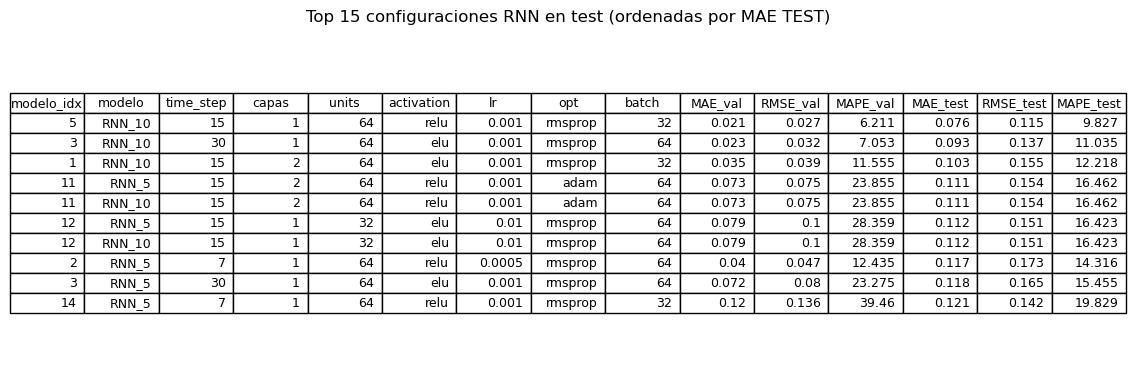

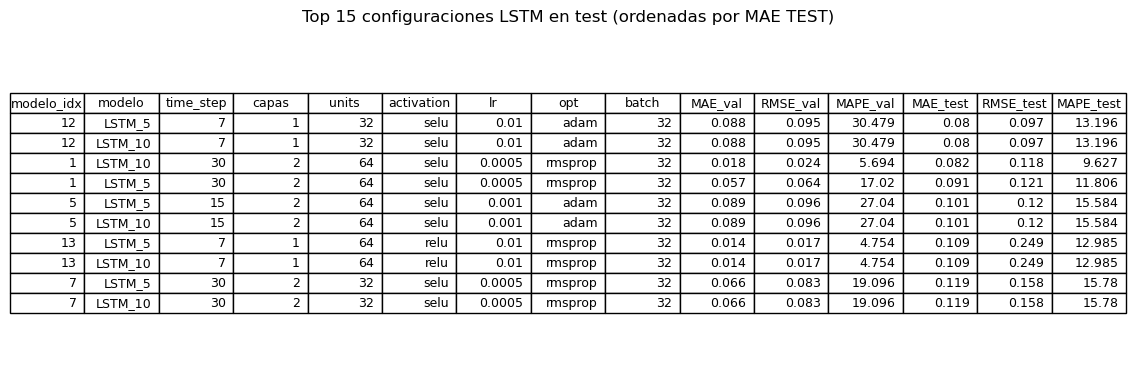

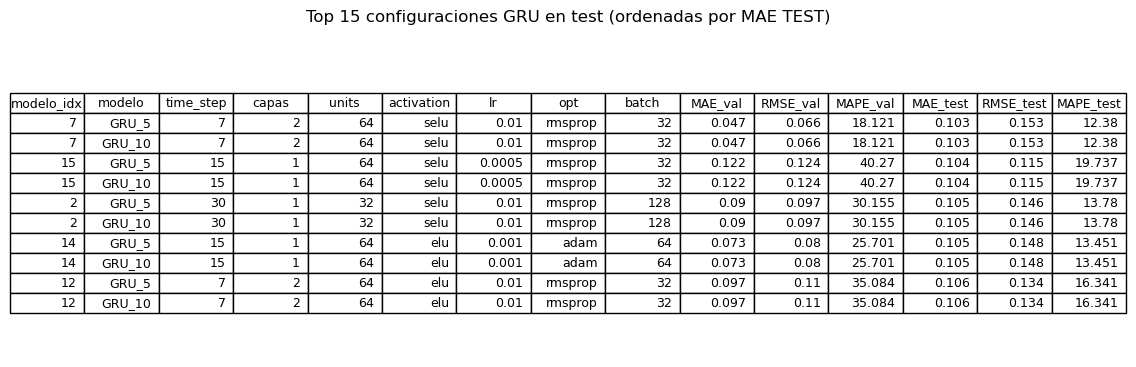

In [61]:
# Archivos RNN
rnn_files = [
    ("RNN_5", "resultados_top15_rnn_epoch100_ES 5.csv"),
    ("RNN_10", "resultados_top15_rnn_epoch100_ES 10.csv"),
]
tabla_rnn = generar_tabla_2(rnn_files, "Top 15 configuraciones RNN en test (ordenadas por MAE TEST)", "tabla_rnn_test.png")


# Archivos LSTM
lstm_files = [
    ("LSTM_5", "resultados_top15_lstm_epoch100_ES 5.csv"),
    ("LSTM_10", "resultados_top15_lstm_epoch100_ES 10.csv"),
]
tabla_lstm = generar_tabla_2(lstm_files, "Top 15 configuraciones LSTM en test (ordenadas por MAE TEST)", "tabla_lstm_test.png")


# Archivos GRU
gru_files = [
    ("GRU_5", "resultados_top15_gru_epoch100_ES 5.csv"),
    ("GRU_10", "resultados_top15_gru_epoch100_ES 10.csv"),
]
tabla_gru = generar_tabla_2(gru_files, "Top 15 configuraciones GRU en test (ordenadas por MAE TEST)", "tabla_gru_test.png")


# Graficos

## Comparacion Metricas validacion

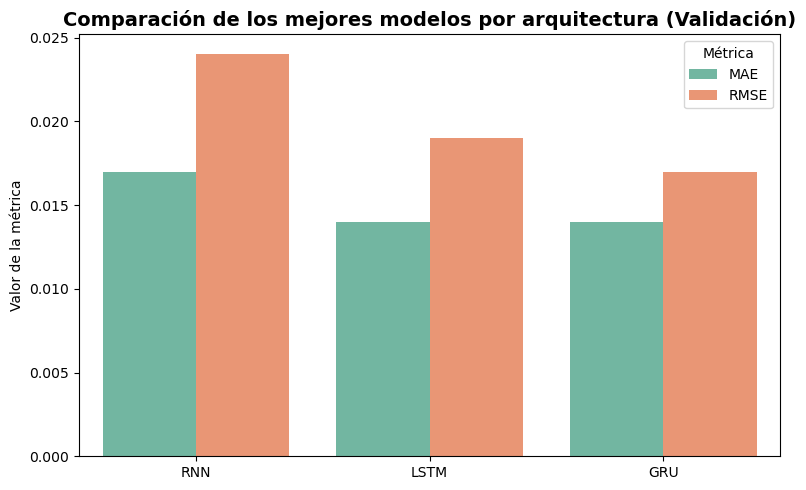

In [62]:
# Datos de validación de los mejores modelos
mejores = pd.DataFrame({
    "Modelo": ["RNN", "LSTM", "GRU"],
    "MAE": [0.017, 0.014, 0.014],
    "RMSE": [0.024, 0.019, 0.017],
})

# Convertimos a formato largo para seaborn
df_long = mejores.melt(id_vars="Modelo", var_name="Métrica", value_name="Valor")

# Gráfico comparativo con Seaborn
plt.figure(figsize=(8,5))
sns.barplot(
    data=df_long,
    x="Modelo", y="Valor", hue="Métrica",
    palette="Set2"
)

plt.title("Comparación de los mejores modelos por arquitectura (Validación)", fontsize=14, weight="bold")
plt.ylabel("Valor de la métrica")
plt.xlabel("")
plt.legend(title="Métrica")
plt.tight_layout()
plt.savefig("Comp de mod en val", dpi=300, bbox_inches="tight")
plt.show()

In [63]:
def comparar_loss(rnn_file=None, lstm_file=None, gru_file=None):
    """
    Compara las curvas de loss/val_loss de los CSV que le pases manualmente.
    Cada archivo debe ser un history guardado (con columnas loss y val_loss).
    
    Parámetros:
        rnn_file: ruta al CSV del modelo RNN
        lstm_file: ruta al CSV del modelo LSTM
        gru_file: ruta al CSV del modelo GRU
    """
    archivos = {
        "RNN": rnn_file,
        "LSTM": lstm_file,
        "GRU": gru_file
    }

    plt.figure(figsize=(10, 6))

    for arch, file in archivos.items():
        if file is None:
            continue
        history_df = pd.read_csv(file)
        plt.plot(history_df["loss"], label=f"{arch} - loss", linestyle="-")
        plt.plot(history_df["val_loss"], label=f"{arch} - val_loss", linestyle="--")

    plt.title("Comparación de loss y val_loss", fontsize=14)
    plt.xlabel("Épocas")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

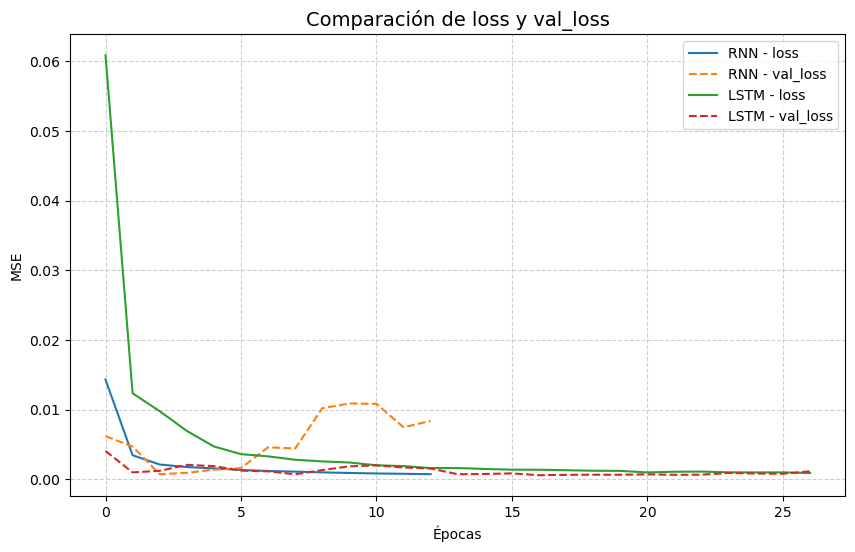

In [64]:
comparar_loss(
    rnn_file="historia_RNN/historia_RNN_modelo5_time15_capas1_units64_actrelu_lr0.001_optrmsprop_batch32_ES10.csv",
    lstm_file="historia_LSTM/historia_LSTM_modelo1_time30_capas2_units64_actselu_lr0.0005_optrmsprop_batch32_ES10.csv",
)

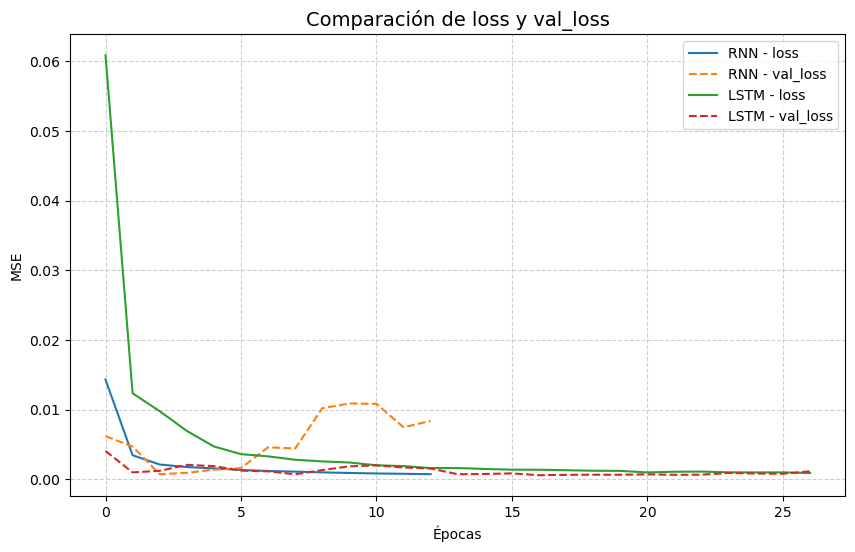

In [65]:
comparar_loss(
    rnn_file="historia_RNN/historia_RNN_modelo5_time15_capas1_units64_actrelu_lr0.001_optrmsprop_batch32_ES10.csv",
    lstm_file="historia_LSTM/historia_LSTM_modelo1_time30_capas2_units64_actselu_lr0.0005_optrmsprop_batch32_ES10.csv",
)

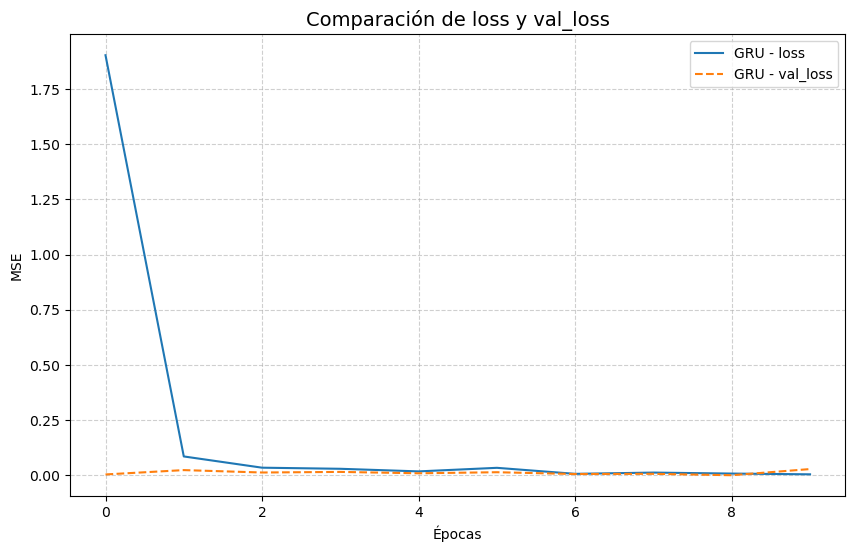

In [66]:
comparar_loss(
    gru_file="historia_GRU/historia_GRU_modelo7_time7_capas2_units64_actselu_lr0.01_optrmsprop_batch32_ES10.csv"
)

# Predicciones recreando los mejores modelos 

### RNN 10 ES modelo idx 5

In [67]:
# Configuración general
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

os.makedirs("mejor_RNN", exist_ok=True)

# EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Hiperparámetros del mejor modelo
time_step = 15
capas = 1
units = 64
activation = "relu"
lr = 0.001
opt = "rmsprop"
batch = 32

print(f"\n🔹 Entrenando modelo RNN_10 con configuración óptima:")


# Cargar datos preprocesados
data = sequences[time_step]
X_train_seq = data["X_train"]
y_train_seq = data["y_train"]
X_val_seq   = data["X_val"]
y_val_seq   = data["y_val"]
X_test_seq  = data["X_test"]
y_test_seq  = data["y_test"]


# Construcción del modelo
model = keras.Sequential()
model.add(layers.SimpleRNN(units, activation=activation, input_shape=(time_step, X_train_seq.shape[2])))
model.add(layers.Dense(1, activation="linear"))

# Optimizador
optimizer = (keras.optimizers.RMSprop(learning_rate=lr)
)

model.compile(optimizer=optimizer, loss="mse")


# Entrenamiento
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=batch,
    verbose=0,
    callbacks=[early_stopping]
)

# Guardar modelo
model.save("mejor_RNN/modelo_RNN10_best.keras")

K.clear_session()



🔹 Entrenando modelo RNN_10 con configuración óptima:


D:\Users\iscor\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### LSTM 10 ES modelo idx 1

In [68]:
# Configuración general
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

os.makedirs("mejor_LSTM", exist_ok=True)

# EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Hiperparámetros del mejor modelo
time_step = 30
capas = 2
units = 64
activation = "selu"
lr = 0.0005
opt = "rmsprop"
batch = 32

print(f"\n🔹 Entrenando modelo LSTM_10 con configuración óptima:")

# Cargar datos preprocesados
data = sequences[time_step]
X_train_seq = data["X_train"]
y_train_seq = data["y_train"]
X_val_seq   = data["X_val"]
y_val_seq   = data["y_val"]
X_test_seq  = data["X_test"]
y_test_seq  = data["y_test"]

# Construcción del modelo
model = keras.Sequential()
model.add(layers.LSTM(units, activation=activation, return_sequences=True, input_shape=(time_step, X_train_seq.shape[2])))
model.add(layers.LSTM(units, activation=activation))
model.add(layers.Dense(1, activation="linear"))

# Optimizador
optimizer = (keras.optimizers.RMSprop(learning_rate=lr)
)

model.compile(optimizer=optimizer, loss="mse")

# Entrenamiento
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=batch,
    verbose=0,
    callbacks=[early_stopping]
)

# Guardar modelo
model.save("mejor_LSTM/modelo_LSTM10_best.keras")

K.clear_session()


🔹 Entrenando modelo LSTM_10 con configuración óptima:


### GRU ES 10 modelo idx7

In [69]:
# Configuración general
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

os.makedirs("mejor_GRU", exist_ok=True)

# EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Hiperparámetros del mejor modelo
time_step = 7
capas = 2
units = 64
activation = "selu"
lr = 0.01
opt = "rmsprop"
batch = 32

print(f"\n🔹 Entrenando modelo GRU_10 con configuración óptima:")

# Cargar datos preprocesados
data = sequences[time_step]
X_train_seq = data["X_train"]
y_train_seq = data["y_train"]
X_val_seq   = data["X_val"]
y_val_seq   = data["y_val"]
X_test_seq  = data["X_test"]
y_test_seq  = data["y_test"]

# Construcción del modelo
model = keras.Sequential()
model.add(layers.GRU(units, activation=activation, return_sequences=True, input_shape=(time_step, X_train_seq.shape[2])))
model.add(layers.GRU(units, activation=activation))
model.add(layers.Dense(1, activation="linear"))

# Optimizador
optimizer = (keras.optimizers.RMSprop(learning_rate=lr)
)

model.compile(optimizer=optimizer, loss="mse")

# Entrenamiento
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=batch,
    verbose=0,
    callbacks=[early_stopping]
)

# Guardar modelo
os.makedirs("mejor_GRU", exist_ok=True)
model.save("mejor_GRU/modelo_GRU10_best.keras")

K.clear_session()



🔹 Entrenando modelo GRU_10 con configuración óptima:


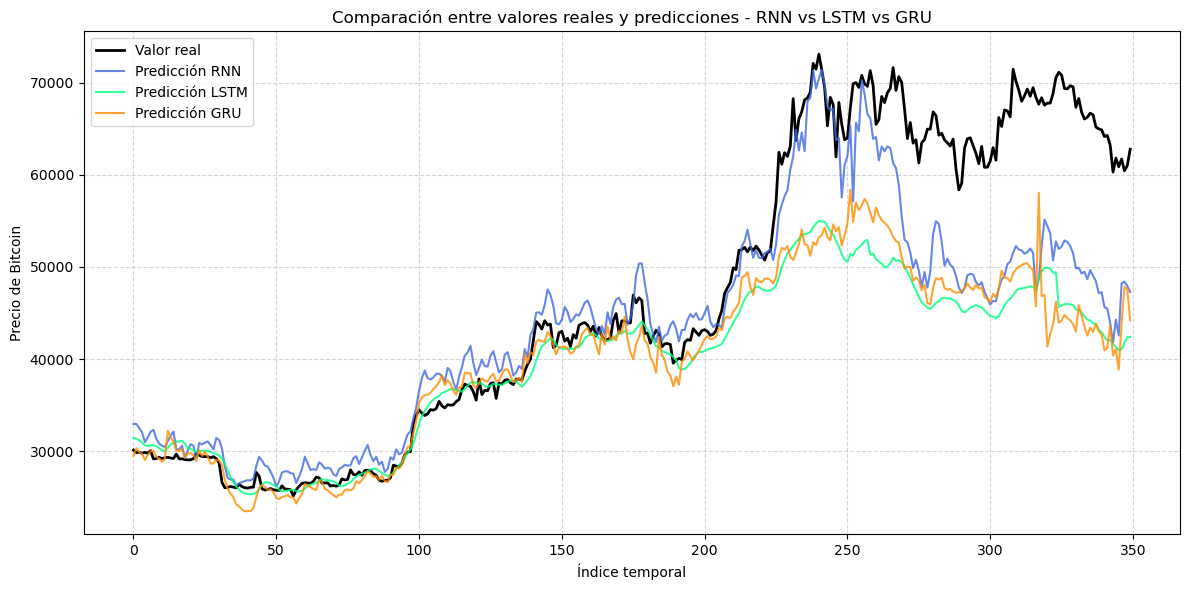

In [70]:
# Cargar modelos entrenados
rnn_model  = load_model("mejor_RNN/modelo_RNN10_best.keras")
lstm_model = load_model("mejor_LSTM/modelo_LSTM10_best.keras")
gru_model  = load_model("mejor_GRU/modelo_GRU10_best.keras")


# Predicciones sobre el conjunto de test
y_pred_rnn  = rnn_model.predict(X_test_seq, verbose=0)
y_pred_lstm = lstm_model.predict(X_test_seq, verbose=0)
y_pred_gru  = gru_model.predict(X_test_seq, verbose=0)

# Si los datos están escalados, descomenta estas líneas para invertir el escalado
y_test_inv      = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))
y_pred_rnn_inv  = scaler_y.inverse_transform(y_pred_rnn)
y_pred_lstm_inv = scaler_y.inverse_transform(y_pred_lstm)
y_pred_gru_inv  = scaler_y.inverse_transform(y_pred_gru)


# Gráfica comparativa
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label="Valor real", color="black", linewidth=2)
plt.plot(y_pred_rnn_inv, label="Predicción RNN", color="royalblue", alpha=0.8)
plt.plot(y_pred_lstm_inv, label="Predicción LSTM", color="springgreen", alpha=0.8)
plt.plot(y_pred_gru_inv, label="Predicción GRU", color="darkorange", alpha=0.8)

plt.title("Comparación entre valores reales y predicciones - RNN vs LSTM vs GRU")
plt.xlabel("Índice temporal")
plt.ylabel("Precio de Bitcoin")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("Comparativa de predicciones.png")
plt.show()
